In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline

### S&P since 1993

In [143]:
df_spy = pd.read_csv('SPY1993.csv')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [144]:
df_spy = df_spy.sort_values(by='Date')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [145]:
## pulls last date in every year

df_spy_yrend = df_spy.groupby(pd.DatetimeIndex(df_spy.Date).to_period('Y'), as_index=False).nth(-1)
df_spy_yrend.head()

,Date,Open,High,Low,Close,Adj Close,Volume
233,1993-12-31,46.937500,47.00000,46.56250,46.593750,27.772987,312900
485,1994-12-30,46.203125,46.25000,45.56250,45.562500,27.883350,2209500
737,1995-12-29,61.468750,61.53125,61.25000,61.484375,38.492661,339200
991,1996-12-31,75.281250,75.37500,73.84375,73.843750,47.152527,1378100
1244,1997-12-31,96.875000,97.62500,96.68750,97.062500,62.936913,4359500


In [146]:
df_spy_yrend[["year", "month", "day"]] = df_spy_yrend["Date"].str.split("-", expand = True)
df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_40937/2944781614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']


In [147]:
df_agg = df_spy_yrend.groupby('year', as_index=False).agg({'Open':'mean','High':'max', 'Low':'min',
                                                           'Adj Close':'mean'})
df_agg.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Adj Close':'adj_close'}, inplace=True)
df_agg.head()

,year,open,high,low,adj_close
0,1993,46.937500,47.00000,46.56250,27.772987
1,1994,46.203125,46.25000,45.56250,27.883350
2,1995,61.468750,61.53125,61.25000,38.492661
3,1996,75.281250,75.37500,73.84375,47.152527
4,1997,96.875000,97.62500,96.68750,62.936913


In [148]:
ret_high = []
ret_low = []

for i in range(len(df_agg)):    
    if i != 0:
        close = df_agg.adj_close[i - 1]
        
        ret_high.append( (df_agg.high[i] - close) / close )
        ret_low.append(  (df_agg.low[i] - close) / close )
    elif i == 0:
        ret_high.append(None)
        ret_low.append(None)

In [149]:
df_agg['ret_high'] = ret_high
df_agg['ret_low'] = ret_low

df_agg.head()

,year,open,high,low,adj_close,ret_high,ret_low
0,1993,46.937500,47.00000,46.56250,27.772987,NaN,NaN
1,1994,46.203125,46.25000,45.56250,27.883350,0.665287,0.640533
2,1995,61.468750,61.53125,61.25000,38.492661,1.206738,1.196651
3,1996,75.281250,75.37500,73.84375,47.152527,0.958165,0.918385
4,1997,96.875000,97.62500,96.68750,62.936913,1.070409,1.050526


In [150]:
## find diff in price in S&P between years

df_agg['pct_change_adj_close'] = df_agg['adj_close'].pct_change()
df_agg.head()

,year,open,high,low,adj_close,ret_high,ret_low,pct_change_adj_close
0,1993,46.937500,47.00000,46.56250,27.772987,NaN,NaN,NaN
1,1994,46.203125,46.25000,45.56250,27.883350,0.665287,0.640533,0.003974
2,1995,61.468750,61.53125,61.25000,38.492661,1.206738,1.196651,0.380489
3,1996,75.281250,75.37500,73.84375,47.152527,0.958165,0.918385,0.224974
4,1997,96.875000,97.62500,96.68750,62.936913,1.070409,1.050526,0.334752


In [151]:
## goal when investing: low volatility

df_agg['volatility'] = (df_agg['high'] - df_agg['low']) / df_agg['adj_close']
df_agg.head()

,year,open,high,low,adj_close,ret_high,ret_low,pct_change_adj_close,volatility
0,1993,46.937500,47.00000,46.56250,27.772987,NaN,NaN,NaN,0.015753
1,1994,46.203125,46.25000,45.56250,27.883350,0.665287,0.640533,0.003974,0.024656
2,1995,61.468750,61.53125,61.25000,38.492661,1.206738,1.196651,0.380489,0.007307
3,1996,75.281250,75.37500,73.84375,47.152527,0.958165,0.918385,0.224974,0.032474
4,1997,96.875000,97.62500,96.68750,62.936913,1.070409,1.050526,0.334752,0.014896


In [152]:
df_agg['year'] = df_agg['year'].astype(int) 
df_agg.head()

,year,open,high,low,adj_close,ret_high,ret_low,pct_change_adj_close,volatility
0,1993,46.937500,47.00000,46.56250,27.772987,NaN,NaN,NaN,0.015753
1,1994,46.203125,46.25000,45.56250,27.883350,0.665287,0.640533,0.003974,0.024656
2,1995,61.468750,61.53125,61.25000,38.492661,1.206738,1.196651,0.380489,0.007307
3,1996,75.281250,75.37500,73.84375,47.152527,0.958165,0.918385,0.224974,0.032474
4,1997,96.875000,97.62500,96.68750,62.936913,1.070409,1.050526,0.334752,0.014896


In [153]:
df_agg.drop(['high', 'low', 'adj_close'], axis=1, inplace=True)
df_agg.head()

,year,open,ret_high,ret_low,pct_change_adj_close,volatility
0,1993,46.937500,NaN,NaN,NaN,0.015753
1,1994,46.203125,0.665287,0.640533,0.003974,0.024656
2,1995,61.468750,1.206738,1.196651,0.380489,0.007307
3,1996,75.281250,0.958165,0.918385,0.224974,0.032474
4,1997,96.875000,1.070409,1.050526,0.334752,0.014896


In [154]:
prev_ret_high = []
prev_ret_low = []
prev_yr_volatility = []

for i in range(len(df_agg)):
    if i != 0:
        prev_ret_high.append( (df_agg.ret_high[i-1]) )
        prev_ret_low.append( (df_agg.ret_low[i-1]))
        prev_yr_volatility.append( (df_agg.volatility[i-1]))
    elif i == 0:
        prev_ret_high.append(None)
        prev_ret_low.append(None)
        prev_yr_volatility.append(None)

In [155]:
df_agg['prev_yr_ret_high'] = prev_ret_high
df_agg['prev_yr_ret_low'] = prev_ret_low
df_agg['prev_yr_volatility'] = prev_yr_volatility

df_agg = df_agg[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low',
                'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]

df_agg.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752


#### LP Commitments (lp_commitments.csv)

In [156]:
## year by year LP commitments

df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [157]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped.head()

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08


In [158]:
## merge S&P data with LP Commitment data

df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})

df_merged = pd.merge(df_agg, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,avg_commitment_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,4.719266e+08,1.149871e+07
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,3.385642e+08,1.182192e+07
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,6.591820e+08,1.560681e+07
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,6.750360e+08,1.330191e+07
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,8.160065e+08,1.211518e+07


In [159]:
df_merged.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,avg_commitment_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,4.719266e+08,1.149871e+07
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,3.385642e+08,1.182192e+07
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,6.591820e+08,1.560681e+07
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,6.750360e+08,1.330191e+07
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,8.160065e+08,1.211518e+07


In [160]:
## look at percent changes in allocation of funds

df_merged['pct_change_fund_size_amt'] = df_merged['avg_fund_size_amt'].pct_change()
df_merged['pct_change_commit_amt'] = df_merged['avg_commitment_amt'].pct_change()

df_merged = df_merged.rename(columns={'avg_commitment_amt':'avg_commit_amt'})
df_merged = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 
                       'prev_yr_ret_low', 'volatility', 'prev_yr_volatility', 'pct_change_adj_close',
                      'avg_fund_size_amt', 'pct_change_fund_size_amt',
                      'avg_commit_amt', 'pct_change_commit_amt']]

df_merged.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,4.719266e+08,NaN,1.149871e+07,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,3.385642e+08,-0.282591,1.182192e+07,0.028109
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,6.591820e+08,0.946992,1.560681e+07,0.320158
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,6.750360e+08,0.024051,1.330191e+07,-0.147685
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,8.160065e+08,0.208834,1.211518e+07,-0.089215


In [161]:
## percent changes for emerging funds in particular

df_emerging = df_merged[df_merged['avg_fund_size_amt'] <= 250000000]
df_emerging.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt


##### No average fund size less than or equal to $250M in LP Commitments data

In [162]:
## correlations

df_merged['pct_change_adj_close'].corr(df_merged['pct_change_fund_size_amt'])

0.11968294100221738

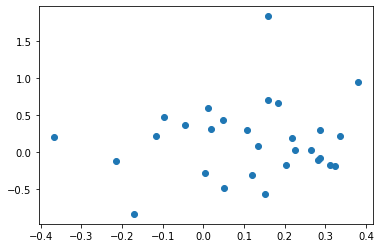

In [163]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.pct_change_fund_size_amt)

In [164]:
df_merged['pct_change_adj_close'].corr(df_merged['avg_fund_size_amt'])

0.07250687220510116

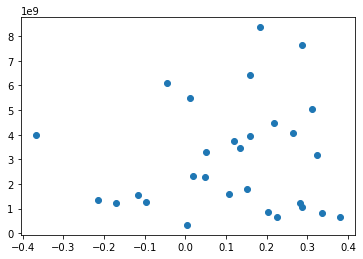

In [165]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.avg_fund_size_amt)

In [166]:
df_merged['volatility'].corr(df_merged['pct_change_fund_size_amt'])

-0.09295513542178833

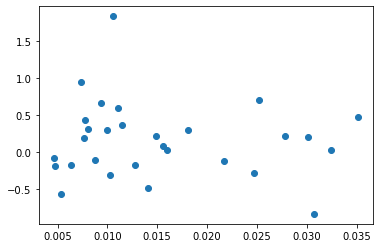

In [167]:
plt.scatter(df_merged.volatility, df_merged.pct_change_fund_size_amt)

In [168]:
df_merged['volatility'].corr(df_merged['avg_fund_size_amt'])

-0.3861680234575997

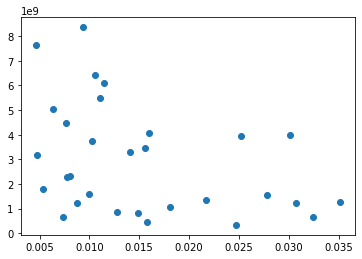

In [169]:
plt.scatter(df_merged.volatility, df_merged.avg_fund_size_amt)

In [170]:
df_merged['pct_change_adj_close'].corr(df_merged['pct_change_commit_amt'])

-0.019635452545019774

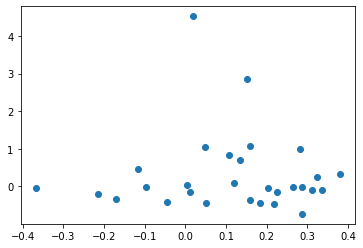

In [171]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.pct_change_commit_amt)

In [172]:
df_merged['pct_change_adj_close'].corr(df_merged['avg_commit_amt'])

0.08788007257110932

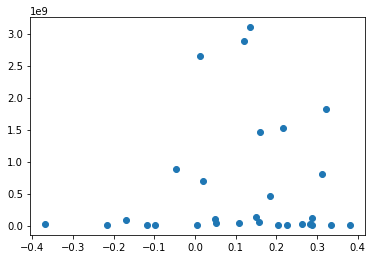

In [173]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.avg_commit_amt)

In [174]:
df_merged['volatility'].corr(df_merged['pct_change_commit_amt'])

-0.215800967194689

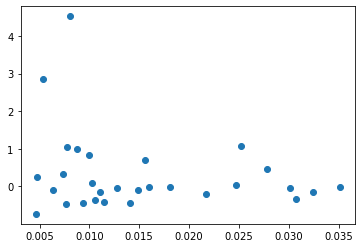

In [175]:
plt.scatter(df_merged.volatility, df_merged.pct_change_commit_amt)

In [176]:
df_merged['volatility'].corr(df_merged['avg_commit_amt'])

-0.2487675677977096

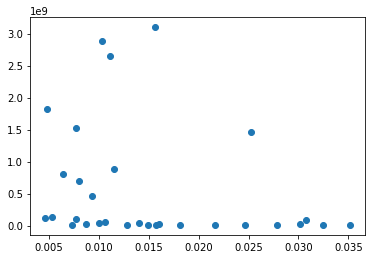

In [177]:
plt.scatter(df_merged.volatility, df_merged.avg_commit_amt)

In [178]:
df_merged.avg_fund_size_amt.nsmallest(5)

1    3.385642e+08
0    4.719266e+08
2    6.591820e+08
3    6.750360e+08
4    8.160065e+08
Name: avg_fund_size_amt, dtype: float64

#### Buyouts Funds (buyouts_funds_final.csv)

In [360]:
## retrying with year by year funds data

df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds = df_funds[df_funds['vintage_year'] != 0]
df_funds = df_funds[df_funds['strategy'] == 'Venture Capital / Growth Equity']
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6177,61228,Altera Vision PA,22927,Venture Capital / Growth Equity,Diversified,North America,NaN,5250000.0,USD,3560000.0,USD,Currently Investing,1st Close,2022,2022-2
6189,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Middle East/Africa,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3
6188,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Central/Eastern Europe,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3
6187,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Western Europe,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3
6186,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Asia-Pacific,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [361]:
df_funds = df_funds[['vintage_year', 'fund_size_amt', 'target_fund_size_amt']]
df_funds.head()

,vintage_year,fund_size_amt,target_fund_size_amt
6177,2022,3560000.0,5250000.0
6189,2022,NaN,200000000.0
6188,2022,NaN,200000000.0
6187,2022,NaN,200000000.0
6186,2022,NaN,200000000.0


In [363]:
df_funds_grouped = df_funds.groupby('vintage_year', as_index=False).agg({'fund_size_amt':'mean',
                                                                        'target_fund_size_amt':'mean'})
df_funds_grouped = df_funds_grouped.sort_values('vintage_year', ascending=False)
df_funds_grouped = df_funds_grouped.rename(columns={'vintage_year':'year', 'fund_size_amt':'avg_fund_size_amt',
                                                   'target_fund_size_amt':'avg_target_fund_size_amt'})
df_funds_grouped.head()

,year,avg_fund_size_amt,avg_target_fund_size_amt
3,2022,2.572668e+08,7.069871e+08
2,2021,9.308735e+08,1.609295e+09
1,2020,7.029287e+07,1.526057e+08
0,2019,7.101308e+07,1.925497e+08


In [182]:
## merge S&P data with funds data

df_merged2 = pd.merge(df_agg, df_funds_grouped, on='year')
df_merged2 = df_merged2.sort_values('year')
df_merged2.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,avg_target_fund_size_amt
0,2019,320.529999,0.359911,0.351552,0.007949,-0.003009,0.006370,0.011483,0.312239,1.436815e+09,3.027148e+08
1,2020,371.779999,0.205324,0.194289,0.359911,0.351552,0.009325,0.006370,0.183316,4.589803e+08,1.141979e+09
2,2021,475.640015,0.296452,0.290498,0.205324,0.194289,0.004625,0.009325,0.287288,8.073735e+08,1.833711e+09
3,2022,398.070007,-0.146675,-0.172188,0.296452,0.290498,0.030758,0.004625,-0.170519,3.468283e+08,3.293141e+09


In [183]:
## look at percent changes in allocation of funds

df_merged2['pct_change_fund_amt'] = df_merged2['avg_fund_size_amt'].pct_change()
df_merged2['pct_change_target_amt'] = df_merged2['avg_target_fund_size_amt'].pct_change()

df_merged2 = df_merged2[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 
                         'prev_yr_ret_low', 'volatility', 'prev_yr_volatility', 'pct_change_adj_close',
                      'avg_fund_size_amt', 'pct_change_fund_amt',
                      'avg_target_fund_size_amt', 'pct_change_target_amt']]

df_merged2.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,2019,320.529999,0.359911,0.351552,0.007949,-0.003009,0.006370,0.011483,0.312239,1.436815e+09,NaN,3.027148e+08,NaN
1,2020,371.779999,0.205324,0.194289,0.359911,0.351552,0.009325,0.006370,0.183316,4.589803e+08,-0.680557,1.141979e+09,2.772458
2,2021,475.640015,0.296452,0.290498,0.205324,0.194289,0.004625,0.009325,0.287288,8.073735e+08,0.759059,1.833711e+09,0.605731
3,2022,398.070007,-0.146675,-0.172188,0.296452,0.290498,0.030758,0.004625,-0.170519,3.468283e+08,-0.570424,3.293141e+09,0.795889


In [184]:
## percent changes for emerging funds in particular

df_emerging2 = df_merged2[df_merged2['avg_fund_size_amt'] <= 250000000]
df_emerging2.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt


##### No average fund size less than or equal to $250M in Funds data

In [185]:
## correlations

df_merged2['pct_change_adj_close'].corr(df_merged2['pct_change_fund_amt'])

0.6234590837464378

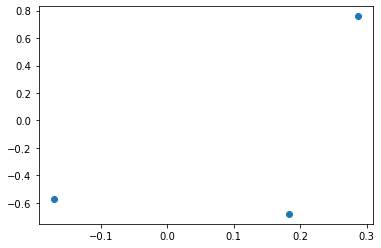

In [186]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.pct_change_fund_amt)

In [187]:
df_merged2['pct_change_adj_close'].corr(df_merged2['avg_fund_size_amt'])

0.7279554094232358

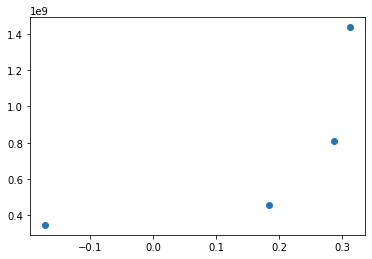

In [188]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.avg_fund_size_amt)

In [189]:
df_merged2['volatility'].corr(df_merged2['pct_change_fund_amt'])

-0.5845520724135566

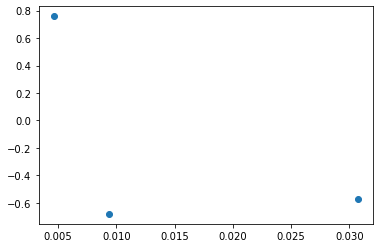

In [190]:
plt.scatter(df_merged2.volatility, df_merged2.pct_change_fund_amt)

In [191]:
df_merged2['volatility'].corr(df_merged2['avg_fund_size_amt'])

-0.6217189931930354

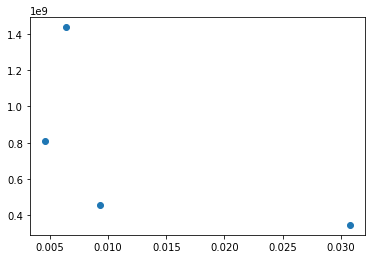

In [192]:
plt.scatter(df_merged2.volatility, df_merged2.avg_fund_size_amt)

In [193]:
df_merged2.avg_fund_size_amt.nsmallest(5)

3    3.468283e+08
1    4.589803e+08
2    8.073735e+08
0    1.436815e+09
Name: avg_fund_size_amt, dtype: float64

#### Buyouts Fund Manager History (buyouts_fm_fund_history.csv)

In [365]:
## retrying with year by year fund history data

df_fund_hist = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_fm_fund_history.csv')
df_fund_hist = df_fund_hist.sort_values('vintage_year', ascending=False)
df_fund_hist = df_fund_hist[df_fund_hist['vintage_year'] != 0]
df_fund_hist = df_fund_hist[df_fund_hist['strategy'] == 'Venture Capital / Growth Equity']
df_fund_hist.head()

,fm_fund_id,fm_id,fund_id,fund_name,vintage_year,region,sector,strategy,fund_size_amt,fund_currency,target_fund_size_amt,target_fund_size_currency
16926,12203,20421,62041,Imaginary Venture Capital EIP Fund III,2022,North America,TMT,Venture Capital / Growth Equity,2250000.0,USD,3000000.0,USD
1481,81,19359,60588,Two Sigma Ventures Opportunity Fund II,2022,North America,TMT,Venture Capital / Growth Equity,0.0,USD,0.0,USD
16925,8145,20421,62041,Imaginary Venture Capital EIP Fund III,2022,North America,Retail,Venture Capital / Growth Equity,2250000.0,USD,3000000.0,USD
16924,4012,20421,62041,Imaginary Venture Capital EIP Fund III,2022,North America,Consumer Goods,Venture Capital / Growth Equity,2250000.0,USD,3000000.0,USD
16923,25722,20421,62041,Imaginary Venture Capital EIP Fund III,2022,Central/Eastern Europe,TMT,Venture Capital / Growth Equity,2250000.0,USD,3000000.0,USD


In [366]:
df_fund_hist = df_fund_hist[['vintage_year', 'fund_size_amt', 'target_fund_size_amt']]
df_fund_hist.head()

,vintage_year,fund_size_amt,target_fund_size_amt
16926,2022,2250000.0,3000000.0
1481,2022,0.0,0.0
16925,2022,2250000.0,3000000.0
16924,2022,2250000.0,3000000.0
16923,2022,2250000.0,3000000.0


In [367]:
df_fund_hist_grouped = df_fund_hist.groupby('vintage_year', as_index=False).agg({'fund_size_amt':'mean',
                                                                        'target_fund_size_amt':'mean'})
df_fund_hist_grouped = df_fund_hist_grouped.sort_values('vintage_year', ascending=False)
df_fund_hist_grouped = df_fund_hist_grouped.rename(columns={'vintage_year':'year',
                                                            'fund_size_amt':'avg_fund_size_amt',
                                                   'target_fund_size_amt':'avg_target_fund_size_amt'})
df_fund_hist_grouped.head()

,year,avg_fund_size_amt,avg_target_fund_size_amt
46,2022,1.100477e+08,4.503077e+08
45,2021,7.871827e+08,1.125082e+09
44,2020,2.073658e+08,1.859586e+08
43,2019,5.176808e+08,4.714203e+08
42,2018,5.220860e+08,3.829770e+08


In [368]:
df_fund_hist_grouped

,year,avg_fund_size_amt,avg_target_fund_size_amt
46,2022,1.100477e+08,4.503077e+08
45,2021,7.871827e+08,1.125082e+09
44,2020,2.073658e+08,1.859586e+08
43,2019,5.176808e+08,4.714203e+08
42,2018,5.220860e+08,3.829770e+08
41,2017,2.940426e+08,3.081583e+08
40,2016,6.507409e+08,5.352023e+08
39,2015,6.635820e+08,3.984538e+08
38,2014,4.656796e+08,4.076500e+08
37,2013,9.110393e+08,8.805738e+08


In [369]:
## merge S&P data with funds data

df_merged3 = pd.merge(df_agg, df_fund_hist_grouped, on='year')
df_merged3 = df_merged3.sort_values('year')
df_merged3.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,avg_target_fund_size_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.211689e+08,0.000000e+00
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,8.491212e+07,4.242424e+06
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,6.994688e+07,7.531250e+05
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.569529e+08,0.000000e+00
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,2.335972e+08,8.902778e+06


In [370]:
## look at percent changes in allocation of funds

df_merged3['pct_change_fund_amt'] = df_merged3['avg_fund_size_amt'].pct_change()
df_merged3['pct_change_target_amt'] = df_merged3['avg_target_fund_size_amt'].pct_change()

df_merged3 = df_merged3[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high',
                         'prev_yr_ret_low', 'volatility', 'prev_yr_volatility', 'pct_change_adj_close',
                      'avg_fund_size_amt', 'pct_change_fund_amt',
                      'avg_target_fund_size_amt', 'pct_change_target_amt']]

df_merged3.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.211689e+08,NaN,0.000000e+00,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,8.491212e+07,-0.299225,4.242424e+06,inf
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,6.994688e+07,-0.176244,7.531250e+05,-0.822478
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.569529e+08,1.243887,0.000000e+00,-1.000000
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,2.335972e+08,0.488327,8.902778e+06,inf


In [372]:
## percent changes for emerging funds in particular

df_emerging3 = df_merged3[df_merged3['avg_fund_size_amt'] <= 250000000]
df_emerging3

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.211689e+08,NaN,0.000000e+00,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,8.491212e+07,-0.299225,4.242424e+06,inf
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,6.994688e+07,-0.176244,7.531250e+05,-0.822478
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.569529e+08,1.243887,0.000000e+00,-1.000000
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,2.335972e+08,0.488327,8.902778e+06,inf
5,1998,123.312500,0.969234,0.945897,1.070409,1.050526,0.018134,0.014896,0.286924,1.891044e+08,-0.190468,2.747253e+07,2.085838
10,2003,111.220001,0.831235,0.820069,0.138655,0.121659,0.008711,0.021675,0.281816,2.327842e+08,-0.296744,2.682083e+07,3.053065
27,2020,371.779999,0.205324,0.194289,0.359911,0.351552,0.009325,0.006370,0.183316,2.073658e+08,-0.599433,1.859586e+08,-0.605535
29,2022,398.070007,-0.146675,-0.172188,0.296452,0.290498,0.030758,0.004625,-0.170519,1.100477e+08,-0.860201,4.503077e+08,-0.599756


##### Average fund sizes in both 1994 and 2022 are the lowest 

In [200]:
## correlations

df_merged3['pct_change_adj_close'].corr(df_merged3['pct_change_fund_amt'])

0.14356006959583786

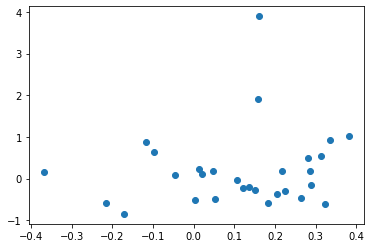

In [201]:
plt.scatter(df_merged3.pct_change_adj_close, df_merged3.pct_change_fund_amt)

In [202]:
df_merged3['pct_change_adj_close'].corr(df_merged3['avg_fund_size_amt'])

0.006328702696983285

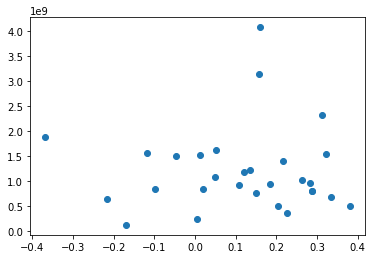

In [203]:
plt.scatter(df_merged3.pct_change_adj_close, df_merged3.avg_fund_size_amt)

In [204]:
df_merged3['volatility'].corr(df_merged3['pct_change_fund_amt'])

0.10399003920576727

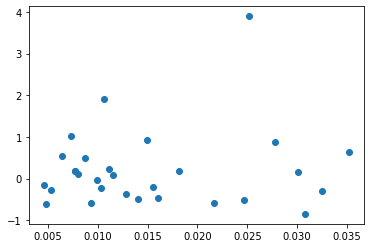

In [205]:
plt.scatter(df_merged3.volatility, df_merged3.pct_change_fund_amt)

In [206]:
df_merged3['volatility'].corr(df_merged3['avg_fund_size_amt'])

-0.055441179109785604

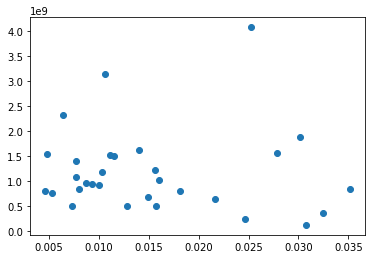

In [207]:
plt.scatter(df_merged3.volatility, df_merged3.avg_fund_size_amt)

#### Buyouts Historical Data (buyouts_historical_funds.csv)

In [373]:
## retrying with year by year fund history data

df_hist = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_historical_funds.csv')
df_hist = df_hist.sort_values('close_year', ascending=False)
df_hist = df_hist[df_hist['close_year'] != 0]
df_hist = df_hist[df_hist['strategy'] == 'Venture Capital / Growth Equity']
df_hist.head()

,fund_id,fund_name,manager_id,manager,close_year,strategy,fund_size_amt,fund_currency
7158,59510,Coral Tree Fund I,22607.0,Coral Tree Partners,2022,Venture Capital / Growth Equity,450000000.0,USD
7064,61899,Fuse Venture Partners Alpha I,7015.0,Ignition Partners,2022,Venture Capital / Growth Equity,159660000.0,USD
7070,61821,Signal Peak Ventures III CIV-A,12537.0,Signal Peak Ventures,2022,Venture Capital / Growth Equity,50960000.0,USD
7069,61796,Frazier Life Sciences XI,6498.0,Frazier Healthcare Partners,2022,Venture Capital / Growth Equity,960000000.0,USD
7068,62028,Legacy Knight Strategic Opportunities Fund,22886.0,Legacy Knight,2022,Venture Capital / Growth Equity,72620000.0,USD


In [374]:
df_hist = df_hist[['close_year', 'fund_size_amt']]
df_hist.head()

,close_year,fund_size_amt
7158,2022,450000000.0
7064,2022,159660000.0
7070,2022,50960000.0
7069,2022,960000000.0
7068,2022,72620000.0


In [375]:
df_hist_grouped = df_hist.groupby('close_year', as_index=False).agg({'fund_size_amt':'mean'})
df_hist_grouped = df_hist_grouped.sort_values('close_year', ascending=False)
df_hist_grouped = df_hist_grouped.rename(columns={'close_year':'year', 'fund_size_amt':'avg_fund_size_amt'})
df_hist_grouped.head()

,year,avg_fund_size_amt
41,2022,6.614948e+08
40,2021,4.060309e+08
39,2020,2.631996e+08
38,2019,2.745854e+08
37,2018,2.299908e+08


In [376]:
df_hist_grouped

,year,avg_fund_size_amt
41,2022,6.614948e+08
40,2021,4.060309e+08
39,2020,2.631996e+08
38,2019,2.745854e+08
37,2018,2.299908e+08
36,2017,4.470483e+08
35,2016,2.455099e+08
34,2015,2.434541e+08
33,2014,2.126154e+08
32,2013,4.021951e+08


In [377]:
## merge S&P data with fund history data

df_merged4 = pd.merge(df_agg, df_hist_grouped, on='year')
df_merged4 = df_merged4.sort_values('year')
df_merged4.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.617220e+08
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,2.250000e+08
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,1.640000e+08
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.462857e+08
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,3.365350e+08


In [378]:
## look at percent changes in allocation of funds

df_merged4['pct_change_fund_amt'] = df_merged4['avg_fund_size_amt'].pct_change()

df_merged4 = df_merged4[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 
                         'prev_yr_ret_low', 'volatility', 'prev_yr_volatility', 'pct_change_adj_close',
                      'avg_fund_size_amt', 'pct_change_fund_amt']]

df_merged4.head()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.617220e+08,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,2.250000e+08,0.391276
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,1.640000e+08,-0.271111
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.462857e+08,-0.108014
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,3.365350e+08,1.300532


In [379]:
## percent changes for emerging funds in particular

df_emerging4 = df_merged4[df_merged4['avg_fund_size_amt'] <= 250000000]
df_emerging4

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.617220e+08,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,2.250000e+08,0.391276
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,1.640000e+08,-0.271111
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.462857e+08,-0.108014
5,1998,123.312500,0.969234,0.945897,1.070409,1.050526,0.018134,0.014896,0.286924,1.941444e+08,-0.423108
9,2002,87.989998,0.138655,0.121659,0.322456,0.297913,0.021675,0.027813,-0.215846,1.664290e+08,-0.394498
10,2003,111.220001,0.831235,0.820069,0.138655,0.121659,0.008711,0.021675,0.281816,1.964729e+08,0.180521
11,2004,121.300003,0.558524,0.547507,0.831235,0.820069,0.009952,0.008711,0.106979,2.278578e+08,0.159741
18,2011,126.019997,0.246063,0.237876,0.428451,0.422323,0.008035,0.005326,0.018950,1.942770e+08,-0.521571
19,2012,139.660004,0.379997,0.350763,0.246063,0.237876,0.025204,0.008035,0.159903,2.333471e+08,0.201105


In [214]:
## correlations

df_merged4['pct_change_adj_close'].corr(df_merged4['pct_change_fund_amt'])

0.02279863557873984

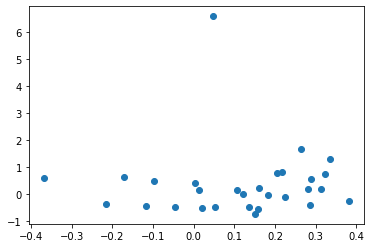

In [215]:
plt.scatter(df_merged4.pct_change_adj_close, df_merged4.pct_change_fund_amt)

In [216]:
df_merged4['pct_change_adj_close'].corr(df_merged4['avg_fund_size_amt'])

-0.058391598215112236

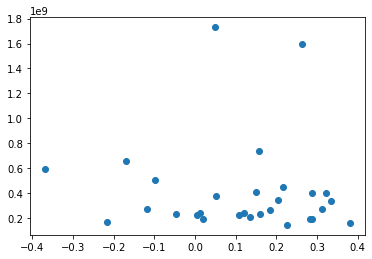

In [217]:
plt.scatter(df_merged4.pct_change_adj_close, df_merged4.avg_fund_size_amt)

In [218]:
df_merged4['volatility'].corr(df_merged4['pct_change_fund_amt'])

-0.09961749515416334

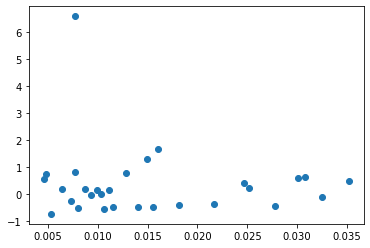

In [219]:
plt.scatter(df_merged4.volatility, df_merged4.pct_change_fund_amt)

In [220]:
df_merged4['volatility'].corr(df_merged4['avg_fund_size_amt'])

-0.03997458194335998

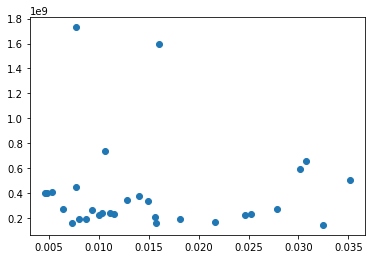

In [221]:
plt.scatter(df_merged4.volatility, df_merged4.avg_fund_size_amt)

In [222]:
## correlations for emerging funds only

df_emerging4['pct_change_adj_close'].corr(df_emerging4['pct_change_fund_amt'])

0.11223063012550955

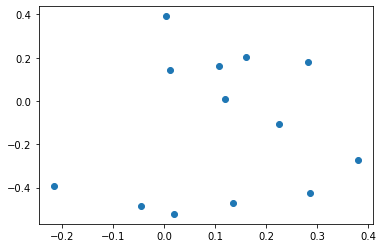

In [223]:
plt.scatter(df_emerging4.pct_change_adj_close, df_emerging4.pct_change_fund_amt)

In [224]:
df_emerging4['pct_change_adj_close'].corr(df_emerging4['avg_fund_size_amt'])

-0.2506289408774063

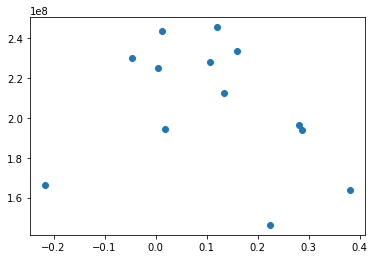

In [225]:
plt.scatter(df_emerging4.pct_change_adj_close, df_emerging4.avg_fund_size_amt)

In [226]:
df_emerging4['volatility'].corr(df_emerging4['pct_change_fund_amt'])

0.18717831014210873

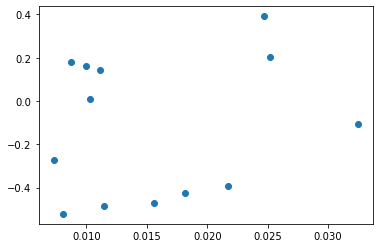

In [227]:
plt.scatter(df_emerging4.volatility, df_emerging4.pct_change_fund_amt)

In [228]:
df_emerging4['volatility'].corr(df_emerging4['avg_fund_size_amt'])

-0.283828584820825

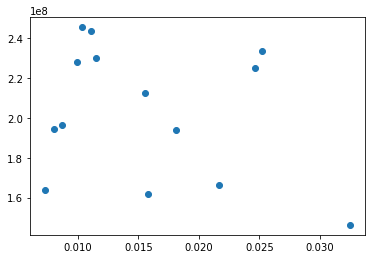

In [229]:
plt.scatter(df_emerging4.volatility, df_emerging4.avg_fund_size_amt)

##### Greater correlation between S&P data and emerging funds specifically

### Linear Regression: S&P vs. LP Commitments (lp_commitments.csv)

In [230]:
df_merged

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,4.719266e+08,NaN,1.149871e+07,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,3.385642e+08,-0.282591,1.182192e+07,0.028109
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,6.591820e+08,0.946992,1.560681e+07,0.320158
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,6.750360e+08,0.024051,1.330191e+07,-0.147685
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,8.160065e+08,0.208834,1.211518e+07,-0.089215
5,1998,123.312500,0.969234,0.945897,1.070409,1.050526,0.018134,0.014896,0.286924,1.055814e+09,0.293880,1.185049e+07,-0.021847
6,1999,146.843750,0.821099,0.805666,0.969234,0.945897,0.012819,0.018134,0.203894,8.717311e+08,-0.174352,1.145844e+07,-0.033083
7,2000,134.062500,0.377111,0.345383,0.821099,0.805666,0.035152,0.012819,-0.097415,1.279754e+09,0.468061,1.126401e+07,-0.016968
8,2001,116.150002,0.322456,0.297913,0.377111,0.345383,0.027813,0.035152,-0.117585,1.553750e+09,0.214100,1.636040e+07,0.452449
9,2002,87.989998,0.138655,0.121659,0.322456,0.297913,0.021675,0.027813,-0.215846,1.364562e+09,-0.121762,1.297006e+07,-0.207229


In [231]:
# using all variables to predict pct_change_fund_size_amt

df_merged.dropna(inplace=True)

model_lp1 = LinearRegression()

#X_lp1 = df_merged.loc[:, df_merged.columns != 'pct_change_fund_size_amt']
X_lp1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high',
                   'prev_yr_ret_low', 'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]
y_lp1 = df_merged.pct_change_fund_size_amt

model_lp1.fit(X_lp1, y_lp1)

rsq_model_lp1 = model_lp1.score(X_lp1, y_lp1)
rsq_model_lp1

0.24337255109373823

In [236]:
X_lp1.corr()

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close
year,1.000000,0.834183,-0.722216,-0.714134,-0.684675,-0.674338,-0.302042,-0.496375,-0.094681
open,0.834183,1.000000,-0.485037,-0.479235,-0.426656,-0.417933,-0.238469,-0.452136,0.069141
ret_high,-0.722216,-0.485037,1.000000,0.999698,0.533971,0.524942,-0.176622,0.387687,0.747902
ret_low,-0.714134,-0.479235,0.999698,1.000000,0.525727,0.516631,-0.199845,0.387889,0.756076
prev_yr_ret_high,-0.684675,-0.426656,0.533971,0.525727,1.000000,0.999679,0.266449,-0.043683,0.090937
prev_yr_ret_low,-0.674338,-0.417933,0.524942,0.516631,0.999679,1.000000,0.267951,-0.067985,0.086827
volatility,-0.302042,-0.238469,-0.176622,-0.199845,0.266449,0.267951,1.000000,0.033086,-0.577985
prev_yr_volatility,-0.496375,-0.452136,0.387687,0.387889,-0.043683,-0.067985,0.033086,1.000000,0.122271
pct_change_adj_close,-0.094681,0.069141,0.747902,0.756076,0.090937,0.086827,-0.577985,0.122271,1.000000


In [239]:
# verify p-value

X_lp1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.175
Model:                                  OLS   Adj. R-squared (uncentered):             -0.050
Method:                       Least Squares   F-statistic:                             0.7785
Date:                      Tue, 31 May 2022   Prob (F-statistic):                       0.596
Time:                              14:05:39   Log-Likelihood:                         -19.473
No. Observations:                        28   AIC:                                      50.95
Df Residuals:                            22   BIC:                                      58.94
Df Model:                                 6                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0002      0.000      0.764      0.453      -0.000       0.001
open                    -0.0008      0.002     -0.457      0.652      -0.005       0.003
ret_high                24.6522     67.948      0.363      0.720    -116.264     165.569
ret_low                -24.4274     67.814     -0.360      0.722    -165.066     116.211
volatility             -32.6717     75.412     -0.433      0.669    -189.067     123.724
pct_change_adj_close    -0.6544      2.282     -0.287      0.777      -5.387       4.078
==============================================================================
Omnibus:                        9.869   Durbin-Watson:                   2.406
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                8.824
Skew:                           0.991   Prob(JB):                       0.0121
Kurtosis:                       4.907   Cond. No.                     2.37e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [240]:
# verify p-value

X_lp1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high',
                   'volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.178
Model:                                  OLS   Adj. R-squared (uncentered):             -0.096
Method:                       Least Squares   F-statistic:                             0.6490
Date:                      Tue, 31 May 2022   Prob (F-statistic):                       0.711
Time:                              14:06:25   Log-Likelihood:                         -19.427
No. Observations:                        28   AIC:                                      52.85
Df Residuals:                            21   BIC:                                      62.18
Df Model:                                 7                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0002      0.000      0.712      0.484      -0.000       0.001
open                    -0.0006      0.002     -0.305      0.763      -0.005       0.004
ret_high                31.7695     74.505      0.426      0.674    -123.173     186.711
ret_low                -31.3306     74.086     -0.423      0.677    -185.402     122.740
prev_yr_ret_high        -0.1389      0.527     -0.263      0.795      -1.235       0.957
volatility             -40.1184     82.082     -0.489      0.630    -210.818     130.581
pct_change_adj_close    -1.0743      2.825     -0.380      0.708      -6.948       4.800
==============================================================================
Omnibus:                        9.375   Durbin-Watson:                   2.398
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.057
Skew:                           0.975   Prob(JB):                       0.0178
Kurtosis:                       4.762   Cond. No.                     2.53e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [241]:
# verify p-value

X_lp1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low',
                   'volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.239
Model:                                  OLS   Adj. R-squared (uncentered):             -0.065
Method:                       Least Squares   F-statistic:                             0.7873
Date:                      Tue, 31 May 2022   Prob (F-statistic):                       0.619
Time:                              14:06:49   Log-Likelihood:                         -18.335
No. Observations:                        28   AIC:                                      52.67
Df Residuals:                            20   BIC:                                      63.33
Df Model:                                 8                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0003      0.000      1.075      0.295      -0.000       0.001
open                    -0.0009      0.002     -0.454      0.655      -0.005       0.003
ret_high                -6.5402     79.352     -0.082      0.935    -172.066     158.986
ret_low                  7.3792     79.091      0.093      0.927    -157.601     172.360
prev_yr_ret_high       -21.2422     16.582     -1.281      0.215     -55.832      13.348
prev_yr_ret_low         21.0601     16.540      1.273      0.218     -13.442      55.562
volatility              -1.1726     86.484     -0.014      0.989    -181.575     179.230
pct_change_adj_close    -0.7577      2.795     -0.271      0.789      -6.587       5.072
==============================================================================
Omnibus:                        4.081   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                2.458
Skew:                           0.630   Prob(JB):                        0.293
Kurtosis:                       3.719   Cond. No.                     2.73e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [242]:
# verify p-value

X_lp1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low',
                   'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.269
Model:                                  OLS   Adj. R-squared (uncentered):             -0.078
Method:                       Least Squares   F-statistic:                             0.7760
Date:                      Tue, 31 May 2022   Prob (F-statistic):                       0.640
Time:                              14:07:34   Log-Likelihood:                         -17.786
No. Observations:                        28   AIC:                                      53.57
Df Residuals:                            19   BIC:                                      65.56
Df Model:                                 9                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0004      0.000      1.315      0.204      -0.000       0.001
open                    -0.0008      0.002     -0.402      0.692      -0.005       0.003
ret_high                18.0735     84.671      0.213      0.833    -159.146     195.293
ret_low                -16.1541     84.017     -0.192      0.850    -192.004     159.696
prev_yr_ret_high        48.2852     81.434      0.593      0.560    -122.159     218.730
prev_yr_ret_low        -49.5895     82.686     -0.600      0.556    -222.653     123.474
volatility             -21.4904     90.070     -0.239      0.814    -210.008     167.028
prev_yr_volatility     -76.8323     88.082     -0.872      0.394    -261.190     107.525
pct_change_adj_close    -2.5288      3.468     -0.729      0.475      -9.788       4.730
==============================================================================
Omnibus:                        2.328   Durbin-Watson:                   2.472
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.096
Skew:                           0.399   Prob(JB):                        0.578
Kurtosis:                       3.550   Cond. No.                     3.28e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [243]:
# verify p-value

X_lp1 = df_merged[['year', 'open', 'prev_yr_ret_high', 'prev_yr_ret_low',
                   'prev_yr_volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.220
Model:                                  OLS   Adj. R-squared (uncentered):              0.008
Method:                       Least Squares   F-statistic:                              1.037
Date:                      Tue, 31 May 2022   Prob (F-statistic):                       0.428
Time:                              14:08:04   Log-Likelihood:                         -18.682
No. Observations:                        28   AIC:                                      49.36
Df Residuals:                            22   BIC:                                      57.36
Df Model:                                 6                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0004      0.000      1.435      0.165      -0.000       0.001
open                    -0.0021      0.002     -1.397      0.176      -0.005       0.001
prev_yr_ret_high        -1.5700     51.668     -0.030      0.976    -108.723     105.583
prev_yr_ret_low          1.4087     52.153      0.027      0.979    -106.751     109.568
prev_yr_volatility     -15.9073     52.614     -0.302      0.765    -125.021      93.207
pct_change_adj_close     0.5021      0.573      0.876      0.391      -0.687       1.691
==============================================================================
Omnibus:                        6.228   Durbin-Watson:                   2.418
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                4.395
Skew:                           0.766   Prob(JB):                        0.111
Kurtosis:                       4.191   Cond. No.                     1.80e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.8e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [244]:
# verify p-value

X_lp1 = df_merged[['year', 'open', 
                   'prev_yr_volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.212
Model:                                  OLS   Adj. R-squared (uncentered):              0.081
Method:                       Least Squares   F-statistic:                              1.619
Date:                      Tue, 31 May 2022   Prob (F-statistic):                       0.202
Time:                              14:08:22   Log-Likelihood:                         -18.825
No. Observations:                        28   AIC:                                      45.65
Df Residuals:                            24   BIC:                                      50.98
Df Model:                                 4                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0003      0.000      2.005      0.056   -9.69e-06       0.001
open                    -0.0018      0.001     -1.695      0.103      -0.004       0.000
prev_yr_volatility     -15.1892     12.638     -1.202      0.241     -41.272      10.894
pct_change_adj_close     0.4482      0.541      0.829      0.415      -0.668       1.564
==============================================================================
Omnibus:                        7.044   Durbin-Watson:                   2.444
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                5.315
Skew:                           0.799   Prob(JB):                       0.0701
Kurtosis:                       4.415   Cond. No.                     2.63e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [317]:
# verify p-value

X_lp1 = df_merged[['prev_yr_ret_high', 'prev_yr_ret_low', 
                   'prev_yr_volatility']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.128
Model:                                  OLS   Adj. R-squared (uncentered):              0.023
Method:                       Least Squares   F-statistic:                              1.219
Date:                      Tue, 31 May 2022   Prob (F-statistic):                       0.323
Time:                              14:40:54   Log-Likelihood:                         -20.257
No. Observations:                        28   AIC:                                      46.51
Df Residuals:                            25   BIC:                                      50.51
Df Model:                                 3                                                  
Covariance Type:                  nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
prev_yr_ret_high     -37.3537     43.248     -0.864      0.396    -126.424      51.717
prev_yr_ret_low       37.8794     43.534      0.870      0.393     -51.780     127.539
prev_yr_volatility    33.6767     38.489      0.875      0.390     -45.592     112.946
==============================================================================
Omnibus:                       10.145   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.578
Skew:                           0.963   Prob(JB):                      0.00832
Kurtosis:                       5.121   Cond. No.                         578.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [353]:
# verify p-value

X_lp1 = df_merged[['ret_high', 'prev_yr_ret_high',  
                   'prev_yr_volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, x_prime)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared:                       0.146
Model:                                  OLS   Adj. R-squared:                 -0.003
Method:                       Least Squares   F-statistic:                    0.9811
Date:                      Wed, 01 Jun 2022   Prob (F-statistic):              0.437
Time:                              11:04:29   Log-Likelihood:                -18.456
No. Observations:                        28   AIC:                             46.91
Df Residuals:                            23   BIC:                             53.57
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3428      0.269      1.274      0.215      -0.214       0.899
ret_high                 1.5171      0.845      1.794      0.086      -0.232       3.266
prev_yr_ret_high        -0.6450      0.532     -1.213      0.237      -1.745       0.455
prev_yr_volatility     -24.3703     15.626     -1.560      0.133     -56.695       7.954
pct_change_adj_close    -1.5770      1.175     -1.342      0.193      -4.008       0.854
==============================================================================
Omnibus:                        3.261   Durbin-Watson:                   2.407
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                1.763
Skew:                           0.459   Prob(JB):                        0.414
Kurtosis:                       3.817   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [354]:
# verify p-value

X_lp1 = df_merged[['ret_low', 'prev_yr_ret_low',  
                   'prev_yr_volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, x_prime)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared:                       0.151
Model:                                  OLS   Adj. R-squared:                  0.003
Method:                       Least Squares   F-statistic:                     1.021
Date:                      Wed, 01 Jun 2022   Prob (F-statistic):              0.417
Time:                              11:04:50   Log-Likelihood:                -18.373
No. Observations:                        28   AIC:                             46.75
Df Residuals:                            23   BIC:                             53.41
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3697      0.274      1.349      0.190      -0.197       0.937
ret_low                  1.5847      0.863      1.836      0.079      -0.201       3.370
prev_yr_ret_low         -0.6681      0.536     -1.246      0.225      -1.777       0.441
prev_yr_volatility     -25.6900     15.996     -1.606      0.122     -58.780       7.400
pct_change_adj_close    -1.6829      1.205     -1.397      0.176      -4.176       0.810
==============================================================================
Omnibus:                        3.025   Durbin-Watson:                   2.413
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                1.581
Skew:                           0.445   Prob(JB):                        0.454
Kurtosis:                       3.750   Cond. No.                         199.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [355]:
# verify p-value

X_lp1 = df_merged[['prev_yr_ret_high', 'prev_yr_ret_low', 
                   'prev_yr_volatility', 'pct_change_adj_close']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, x_prime)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared:                       0.055
Model:                                  OLS   Adj. R-squared:                 -0.109
Method:                       Least Squares   F-statistic:                    0.3353
Date:                      Wed, 01 Jun 2022   Prob (F-statistic):              0.851
Time:                              11:04:59   Log-Likelihood:                -19.868
No. Observations:                        28   AIC:                             49.74
Df Residuals:                            23   BIC:                             56.40
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1076      0.262      0.410      0.685      -0.435       0.650
prev_yr_ret_high       -38.0325     45.476     -0.836      0.412    -132.106      56.041
prev_yr_ret_low         38.4445     45.804      0.839      0.410     -56.307     133.196
prev_yr_volatility      29.1325     42.394      0.687      0.499     -58.567     116.832
pct_change_adj_close     0.3636      0.576      0.631      0.534      -0.829       1.556
==============================================================================
Omnibus:                        8.383   Durbin-Watson:                   2.334
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                6.992
Skew:                           0.870   Prob(JB):                       0.0303
Kurtosis:                       4.721   Cond. No.                         919.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [356]:
# verify p-value

X_lp1 = df_merged[['prev_yr_ret_low']]

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, x_prime)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared:                       0.010
Model:                                  OLS   Adj. R-squared:                 -0.028
Method:                       Least Squares   F-statistic:                    0.2754
Date:                      Wed, 01 Jun 2022   Prob (F-statistic):              0.604
Time:                              11:05:12   Log-Likelihood:                -20.514
No. Observations:                        28   AIC:                             45.03
Df Residuals:                            26   BIC:                             47.69
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0962      0.173      0.557      0.582      -0.259       0.451
prev_yr_ret_low     0.1624      0.309      0.525      0.604      -0.474       0.798
==============================================================================
Omnibus:                       10.994   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.325
Skew:                           0.978   Prob(JB):                      0.00347
Kurtosis:                       5.425   Cond. No.                         3.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Regression: S&P vs. Buyouts Fund Manager History (buyouts_fm_fund_history.csv)

In [254]:
df_merged3

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,4.990383e+08,1.014791,2.676641e+07,-0.815950
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,3.518425e+08,-0.294959,5.550826e+07,1.073803
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,6.744599e+08,0.916937,2.132325e+08,2.841455
5,1998,123.312500,0.969234,0.945897,1.070409,1.050526,0.018134,0.014896,0.286924,7.971730e+08,0.181943,1.598099e+08,-0.250537
6,1999,146.843750,0.821099,0.805666,0.969234,0.945897,0.012819,0.018134,0.203894,5.103882e+08,-0.359752,6.490265e+07,-0.593876
7,2000,134.062500,0.377111,0.345383,0.821099,0.805666,0.035152,0.012819,-0.097415,8.341124e+08,0.634271,2.451806e+08,2.777667
8,2001,116.150002,0.322456,0.297913,0.377111,0.345383,0.027813,0.035152,-0.117585,1.563546e+09,0.874503,3.085000e+08,0.258256
9,2002,87.989998,0.138655,0.121659,0.322456,0.297913,0.021675,0.027813,-0.215846,6.409040e+08,-0.590096,2.676473e+08,-0.132424
10,2003,111.220001,0.831235,0.820069,0.138655,0.121659,0.008711,0.021675,0.281816,9.531811e+08,0.487245,3.466624e+08,0.295221
11,2004,121.300003,0.558524,0.547507,0.831235,0.820069,0.009952,0.008711,0.106979,9.145001e+08,-0.040581,3.188119e+08,-0.080339


In [255]:
# using all variables to predict pct_change_fund_amt

df_merged3.dropna(inplace=True)

model_fm1 = LinearRegression()

X_fm1 = df_merged3[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 
                    'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]
y_fm1 = df_merged3.pct_change_fund_amt

model_fm1.fit(X_fm1, y_fm1)

rsq_model_fm1 = model_fm1.score(X_fm1, y_fm1)
rsq_model_fm1

0.6196138688847935

In [256]:
# verify p-value

X_fm1 = df_merged3[['year', 'open', 'ret_high', 'ret_low', 'volatility', 'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.232
Model:                             OLS   Adj. R-squared (uncentered):              0.023
Method:                  Least Squares   F-statistic:                              1.110
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.388
Time:                         14:23:57   Log-Likelihood:                         -34.549
No. Observations:                   28   AIC:                                      81.10
Df Residuals:                       22   BIC:                                      89.09
Df Model:                            6                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0004      0.000      0.864      0.397      -0.001       0.001
open                    -0.0052      0.003     -1.643      0.115      -0.012       0.001
ret_high               -18.4188    116.420     -0.158      0.876    -259.859     223.021
ret_low                 16.4455    116.190      0.142      0.889    -224.518     257.409
volatility              61.1807    129.208      0.474      0.641    -206.781     329.142
pct_change_adj_close     5.1706      3.910      1.322      0.200      -2.938      13.279
==============================================================================
Omnibus:                       12.367   Durbin-Watson:                   2.421
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.967
Skew:                           1.119   Prob(JB):                      0.00153
Kurtosis:                       5.471   Cond. No.                     2.37e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [257]:
# verify p-value

X_fm1 = df_merged3[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'volatility', 'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.251
Model:                             OLS   Adj. R-squared (uncentered):              0.001
Method:                  Least Squares   F-statistic:                              1.003
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.456
Time:                         14:24:03   Log-Likelihood:                         -34.212
No. Observations:                   28   AIC:                                      82.42
Df Residuals:                       21   BIC:                                      91.75
Df Model:                            7                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0003      0.000      0.765      0.453      -0.001       0.001
open                    -0.0042      0.004     -1.204      0.242      -0.012       0.003
ret_high                14.3884    126.332      0.114      0.910    -248.333     277.109
ret_low                -15.3751    125.621     -0.122      0.904    -276.619     245.869
prev_yr_ret_high        -0.6401      0.894     -0.716      0.482      -2.499       1.219
volatility              26.8547    139.179      0.193      0.849    -262.584     316.294
pct_change_adj_close     3.2352      4.789      0.676      0.507      -6.725      13.195
==============================================================================
Omnibus:                       11.549   Durbin-Watson:                   2.396
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.916
Skew:                           0.968   Prob(JB):                      0.00157
Kurtosis:                       5.707   Cond. No.                     2.53e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [258]:
# verify p-value

X_fm1 = df_merged3[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 
                    'prev_yr_ret_low', 'volatility', 'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.269
Model:                             OLS   Adj. R-squared (uncentered):             -0.024
Method:                  Least Squares   F-statistic:                             0.9181
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.522
Time:                         14:24:05   Log-Likelihood:                         -33.872
No. Observations:                   28   AIC:                                      83.74
Df Residuals:                       20   BIC:                                      94.40
Df Model:                            8                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0005      0.000      0.933      0.362      -0.001       0.001
open                    -0.0045      0.004     -1.262      0.221      -0.012       0.003
ret_high               -22.3513    138.210     -0.162      0.873    -310.652     265.949
ret_low                 21.7483    137.754      0.158      0.876    -265.602     309.098
prev_yr_ret_high       -20.8785     28.882     -0.723      0.478     -81.125      39.368
prev_yr_ret_low         20.1970     28.808      0.701      0.491     -39.896      80.290
volatility              64.2044    150.631      0.426      0.674    -250.006     378.415
pct_change_adj_close     3.5389      4.868      0.727      0.476      -6.615      13.693
==============================================================================
Omnibus:                       10.644   Durbin-Watson:                   2.456
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.108
Skew:                           0.926   Prob(JB):                      0.00387
Kurtosis:                       5.468   Cond. No.                     2.73e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [259]:
# verify p-value

X_fm1 = df_merged3[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 
                    'prev_yr_ret_low', 'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.554
Model:                             OLS   Adj. R-squared (uncentered):              0.343
Method:                  Least Squares   F-statistic:                              2.625
Date:                 Tue, 31 May 2022   Prob (F-statistic):                      0.0367
Time:                         14:24:14   Log-Likelihood:                         -26.939
No. Observations:                   28   AIC:                                      71.88
Df Residuals:                       19   BIC:                                      83.87
Df Model:                            9                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0010      0.000      2.368      0.029       0.000       0.002
open                    -0.0040      0.003     -1.379      0.184      -0.010       0.002
ret_high               114.1813    117.412      0.972      0.343    -131.565     359.928
ret_low               -108.7911    116.505     -0.934      0.362    -352.640     135.057
prev_yr_ret_high       364.7898    112.924      3.230      0.004     128.438     601.142
prev_yr_ret_low       -371.6968    114.659     -3.242      0.004    -611.681    -131.713
volatility             -48.4986    124.898     -0.388      0.702    -309.913     212.916
prev_yr_volatility    -426.1887    122.142     -3.489      0.002    -681.834    -170.543
pct_change_adj_close    -6.2855      4.809     -1.307      0.207     -16.351       3.780
==============================================================================
Omnibus:                        2.157   Durbin-Watson:                   2.389
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.337
Skew:                           0.533   Prob(JB):                        0.512
Kurtosis:                       3.099   Cond. No.                     3.28e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [291]:
# verify p-value

X_fm1 = df_merged3[['year', 'open', 'prev_yr_ret_high', 
                    'prev_yr_ret_low', 'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.249
Model:                             OLS   Adj. R-squared (uncentered):              0.044
Method:                  Least Squares   F-statistic:                              1.215
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.336
Time:                         14:36:08   Log-Likelihood:                         -34.244
No. Observations:                   28   AIC:                                      80.49
Df Residuals:                       22   BIC:                                      88.48
Df Model:                            6                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0011      0.000      2.240      0.036     8.3e-05       0.002
open                    -0.0060      0.003     -2.261      0.034      -0.012      -0.000
prev_yr_ret_high        90.8739     90.076      1.009      0.324     -95.933     277.681
prev_yr_ret_low        -92.5458     90.923     -1.018      0.320    -281.108      96.016
prev_yr_volatility    -118.0028     91.725     -1.286      0.212    -308.229      72.223
pct_change_adj_close     1.0977      1.000      1.098      0.284      -0.975       3.171
==============================================================================
Omnibus:                       19.365   Durbin-Watson:                   2.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.103
Skew:                           1.626   Prob(JB):                     2.15e-06
Kurtosis:                       6.435   Cond. No.                     1.80e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.8e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [324]:
# verify p-value

X_fm1 = df_merged3[['ret_high', 'prev_yr_ret_high', 
                    'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.143
Model:                             OLS   Adj. R-squared (uncentered):              0.000
Method:                  Least Squares   F-statistic:                              1.003
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.426
Time:                         15:00:54   Log-Likelihood:                         -36.088
No. Observations:                   28   AIC:                                      80.18
Df Residuals:                       24   BIC:                                      85.50
Df Model:                            4                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ret_high                 2.1075      1.419      1.486      0.150      -0.820       5.035
prev_yr_ret_high        -0.8449      0.743     -1.137      0.267      -2.378       0.688
prev_yr_volatility     -12.6070     19.655     -0.641      0.527     -53.173      27.959
pct_change_adj_close    -1.7882      1.971     -0.907      0.373      -5.856       2.279
==============================================================================
Omnibus:                       34.823   Durbin-Watson:                   2.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.763
Skew:                           2.464   Prob(JB):                     2.17e-22
Kurtosis:                      10.824   Cond. No.                         85.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [325]:
# verify p-value

X_fm1 = df_merged3[['ret_high', 'prev_yr_ret_high', 
                    'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.128
Model:                             OLS   Adj. R-squared (uncentered):              0.024
Method:                  Least Squares   F-statistic:                              1.229
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.320
Time:                         15:01:06   Log-Likelihood:                         -36.325
No. Observations:                   28   AIC:                                      78.65
Df Residuals:                       25   BIC:                                      82.65
Df Model:                            3                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ret_high                 1.5356      1.090      1.408      0.171      -0.710       3.781
prev_yr_ret_high        -0.7403      0.716     -1.034      0.311      -2.215       0.735
pct_change_adj_close    -1.2386      1.754     -0.706      0.487      -4.850       2.373
==============================================================================
Omnibus:                       35.228   Durbin-Watson:                   2.366
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.064
Skew:                           2.486   Prob(JB):                     4.17e-23
Kurtosis:                      10.976   Cond. No.                         9.11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [326]:
# verify p-value

X_fm1 = df_merged3[['ret_low', 'prev_yr_ret_low', 
                    'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.132
Model:                             OLS   Adj. R-squared (uncentered):             -0.013
Method:                  Least Squares   F-statistic:                             0.9124
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.473
Time:                         15:01:23   Log-Likelihood:                         -36.269
No. Observations:                   28   AIC:                                      80.54
Df Residuals:                       24   BIC:                                      85.87
Df Model:                            4                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ret_low                  1.9586      1.432      1.367      0.184      -0.998       4.915
prev_yr_ret_low         -0.7515      0.733     -1.025      0.316      -2.265       0.762
prev_yr_volatility     -11.0979     19.540     -0.568      0.575     -51.426      29.231
pct_change_adj_close    -1.6310      2.002     -0.815      0.423      -5.763       2.501
==============================================================================
Omnibus:                       35.794   Durbin-Watson:                   2.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.079
Skew:                           2.532   Prob(JB):                     9.23e-24
Kurtosis:                      11.080   Cond. No.                         82.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [327]:
# verify p-value

X_fm1 = df_merged3[['ret_low', 'prev_yr_ret_low', 
                    'pct_change_adj_close']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.120
Model:                             OLS   Adj. R-squared (uncentered):              0.015
Method:                  Least Squares   F-statistic:                              1.140
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.352
Time:                         15:01:36   Log-Likelihood:                         -36.456
No. Observations:                   28   AIC:                                      78.91
Df Residuals:                       25   BIC:                                      82.91
Df Model:                            3                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ret_low                  1.4451      1.096      1.319      0.199      -0.812       3.702
prev_yr_ret_low         -0.6618      0.707     -0.937      0.358      -2.117       0.793
pct_change_adj_close    -1.1350      1.777     -0.639      0.529      -4.794       2.524
==============================================================================
Omnibus:                       35.871   Durbin-Watson:                   2.376
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.055
Skew:                           2.533   Prob(JB):                     5.67e-24
Kurtosis:                      11.130   Cond. No.                         8.92
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [352]:
# verify p-value

X_fm1 = df_merged3[['ret_low']]

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.089
Model:                             OLS   Adj. R-squared (uncentered):              0.055
Method:                  Least Squares   F-statistic:                              2.641
Date:                 Tue, 31 May 2022   Prob (F-statistic):                       0.116
Time:                         18:38:15   Log-Likelihood:                         -36.944
No. Observations:                   28   AIC:                                      75.89
Df Residuals:                       27   BIC:                                      77.22
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ret_low        0.5187      0.319      1.625      0.116      -0.136       1.174
==============================================================================
Omnibus:                       34.971   Durbin-Watson:                   2.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.080
Skew:                           2.510   Prob(JB):                     8.30e-22
Kurtosis:                      10.617   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Regression: S&P vs. Buyouts Historical Data (buyouts_historical_funds.csv)

In [380]:
df_merged4

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.617220e+08,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,2.250000e+08,0.391276
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,1.640000e+08,-0.271111
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.462857e+08,-0.108014
4,1997,96.875000,1.070409,1.050526,0.958165,0.918385,0.014896,0.032474,0.334752,3.365350e+08,1.300532
5,1998,123.312500,0.969234,0.945897,1.070409,1.050526,0.018134,0.014896,0.286924,1.941444e+08,-0.423108
6,1999,146.843750,0.821099,0.805666,0.969234,0.945897,0.012819,0.018134,0.203894,3.440412e+08,0.772089
7,2000,134.062500,0.377111,0.345383,0.821099,0.805666,0.035152,0.012819,-0.097415,5.022335e+08,0.459806
8,2001,116.150002,0.322456,0.297913,0.377111,0.345383,0.027813,0.035152,-0.117585,2.748611e+08,-0.452722
9,2002,87.989998,0.138655,0.121659,0.322456,0.297913,0.021675,0.027813,-0.215846,1.664290e+08,-0.394498


In [381]:
# using all variables to predict pct_change_fund_amt

df_merged4.dropna(inplace=True)

model_hist1 = LinearRegression()

X_hist1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 
                     'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]
y_hist1 = df_merged4.pct_change_fund_amt

model_hist1.fit(X_hist1, y_hist1)

rsq_model_hist1 = model_hist1.score(X_hist1, y_hist1)
rsq_model_hist1

0.044987273485172175

In [382]:
# verify p-value

X_hist1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.026
Model:                             OLS   Adj. R-squared:                 -0.252
Method:                  Least Squares   F-statistic:                   0.09489
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.996
Time:                         14:12:23   Log-Likelihood:                -47.493
No. Observations:                   28   AIC:                             109.0
Df Residuals:                       21   BIC:                             118.3
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.6943    497.489      0.030      0.977   -1019.891    1049.279
year                    -0.0071      0.247     -0.029      0.977      -0.520       0.506
open                     0.0013      0.006      0.217      0.830      -0.011       0.014
ret_high                 8.1491    190.729      0.043      0.966    -388.494     404.792
ret_low                 -7.1690    191.496     -0.037      0.970    -405.406     391.068
volatility             -40.7503    212.412     -0.192      0.850    -482.484     400.984
pct_change_adj_close    -2.3564     11.041     -0.213      0.833     -25.318      20.605
==============================================================================
Omnibus:                       44.586   Durbin-Watson:                   2.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.003
Skew:                           3.098   Prob(JB):                     1.23e-42
Kurtosis:                      14.271   Cond. No.                     3.52e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [383]:
# verify p-value

X_hist1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.040
Model:                             OLS   Adj. R-squared:                 -0.297
Method:                  Least Squares   F-statistic:                    0.1177
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.996
Time:                         14:12:33   Log-Likelihood:                -47.302
No. Observations:                   28   AIC:                             110.6
Df Residuals:                       20   BIC:                             121.3
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   49.2124    510.588      0.096      0.924   -1015.856    1114.281
year                    -0.0243      0.253     -0.096      0.925      -0.553       0.504
open                     0.0027      0.007      0.409      0.687      -0.011       0.016
ret_high                49.3980    209.487      0.236      0.816    -387.584     486.380
ret_low                -47.7639    209.745     -0.228      0.822    -485.285     389.757
prev_yr_ret_high        -0.7720      1.474     -0.524      0.606      -3.847       2.303
volatility             -84.3802    231.680     -0.364      0.720    -567.657     398.897
pct_change_adj_close    -4.0641     11.701     -0.347      0.732     -28.472      20.344
==============================================================================
Omnibus:                       44.180   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.321
Skew:                           3.059   Prob(JB):                     4.70e-42
Kurtosis:                      14.212   Cond. No.                     3.58e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [385]:
# verify p-value

X_hist1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 
                     'volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.041
Model:                             OLS   Adj. R-squared:                 -0.363
Method:                  Least Squares   F-statistic:                    0.1008
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.999
Time:                         14:12:45   Log-Likelihood:                -47.285
No. Observations:                   28   AIC:                             112.6
Df Residuals:                       19   BIC:                             124.6
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   69.8088    541.046      0.129      0.899   -1062.613    1202.230
year                    -0.0344      0.268     -0.128      0.899      -0.596       0.527
open                     0.0027      0.007      0.402      0.692      -0.011       0.017
ret_high                37.2601    229.373      0.162      0.873    -442.824     517.344
ret_low                -35.7925    229.237     -0.156      0.878    -515.590     444.005
prev_yr_ret_high        -8.2352     49.492     -0.166      0.870    -111.822      95.352
prev_yr_ret_low          7.4403     49.317      0.151      0.882     -95.780     110.661
volatility             -72.3634    250.554     -0.289      0.776    -596.780     452.053
pct_change_adj_close    -3.6016     12.383     -0.291      0.774     -29.520      22.317
==============================================================================
Omnibus:                       43.364   Durbin-Watson:                   2.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.133
Skew:                           3.006   Prob(JB):                     7.67e-40
Kurtosis:                      13.875   Cond. No.                     3.65e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [386]:
# verify p-value

X_hist1 = df_merged[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 
                     'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.045
Model:                             OLS   Adj. R-squared:                 -0.433
Method:                  Least Squares   F-statistic:                   0.09421
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.999
Time:                         14:12:48   Log-Likelihood:                -47.223
No. Observations:                   28   AIC:                             114.4
Df Residuals:                       18   BIC:                             127.8
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  126.5253    589.523      0.215      0.832   -1112.017    1365.068
year                    -0.0625      0.292     -0.214      0.833      -0.676       0.552
open                     0.0031      0.007      0.445      0.662      -0.012       0.018
ret_high                63.7619    252.990      0.252      0.804    -467.751     595.274
ret_low                -62.0189    252.503     -0.246      0.809    -592.508     468.471
prev_yr_ret_high        61.1377    249.601      0.245      0.809    -463.255     585.530
prev_yr_ret_low        -63.0978    253.586     -0.249      0.806    -595.861     469.666
volatility             -95.4098    269.372     -0.354      0.727    -661.340     470.521
prev_yr_volatility     -78.1295    275.239     -0.284      0.780    -656.384     500.125
pct_change_adj_close    -4.4174     13.015     -0.339      0.738     -31.762      22.927
==============================================================================
Omnibus:                       42.803   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.292
Skew:                           2.970   Prob(JB):                     2.34e-38
Kurtosis:                      13.642   Cond. No.                     4.20e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [387]:
# verify p-value

X_hist1 = df_merged[['open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 
                     'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.043
Model:                             OLS   Adj. R-squared:                 -0.361
Method:                  Least Squares   F-statistic:                    0.1056
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.999
Time:                         14:12:55   Log-Likelihood:                -47.258
No. Observations:                   28   AIC:                             112.5
Df Residuals:                       19   BIC:                             124.5
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5271      1.742      0.303      0.765      -3.118       4.173
open                     0.0024      0.006      0.400      0.693      -0.010       0.015
ret_high                54.1169    242.601      0.223      0.826    -453.652     561.886
ret_low                -50.8256    240.729     -0.211      0.835    -554.677     453.026
prev_yr_ret_high        46.0935    233.379      0.198      0.846    -442.375     534.561
prev_yr_ret_low        -47.7102    236.966     -0.201      0.843    -543.685     448.265
volatility             -84.8546    258.071     -0.329      0.746    -625.003     455.294
prev_yr_volatility     -58.2536    252.463     -0.231      0.820    -586.664     470.157
pct_change_adj_close    -6.1465      9.936     -0.619      0.544     -26.943      14.650
==============================================================================
Omnibus:                       43.491   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.990
Skew:                           3.012   Prob(JB):                     3.03e-40
Kurtosis:                      13.940   Cond. No.                     3.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [388]:
# verify p-value

X_hist1 = df_merged[['ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 
                     'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.034
Model:                             OLS   Adj. R-squared:                 -0.303
Method:                  Least Squares   F-statistic:                    0.1021
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.998
Time:                         14:13:01   Log-Likelihood:                -47.376
No. Observations:                   28   AIC:                             110.8
Df Residuals:                       20   BIC:                             121.4
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9935      1.267      0.784      0.442      -1.650       3.637
ret_high                17.7763    220.204      0.081      0.936    -441.560     477.113
ret_low                -15.6689    219.383     -0.071      0.944    -473.294     441.956
prev_yr_ret_high        39.0491    227.777      0.171      0.866    -436.085     514.183
prev_yr_ret_low        -40.3511    231.239     -0.175      0.863    -522.707     442.004
volatility             -42.9309    230.863     -0.186      0.854    -524.503     438.642
prev_yr_volatility     -52.6385    246.724     -0.213      0.833    -567.296     462.019
pct_change_adj_close    -3.6244      7.521     -0.482      0.635     -19.312      12.063
==============================================================================
Omnibus:                       43.981   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.324
Skew:                           3.043   Prob(JB):                     1.28e-41
Kurtosis:                      14.152   Cond. No.                     2.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [389]:
# verify p-value

X_hist1 = df_merged[['prev_yr_ret_high', 'prev_yr_ret_low', 
                     'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.021
Model:                             OLS   Adj. R-squared:                 -0.201
Method:                  Least Squares   F-statistic:                   0.09508
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.992
Time:                         14:13:06   Log-Likelihood:                -47.568
No. Observations:                   28   AIC:                             107.1
Df Residuals:                       22   BIC:                             115.1
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6223      0.883      0.705      0.488      -1.209       2.453
prev_yr_ret_high       -48.0176    135.924     -0.353      0.727    -329.907     233.872
prev_yr_ret_low         48.4783    137.073      0.354      0.727    -235.793     332.750
volatility             -28.4470     45.962     -0.619      0.542    -123.767      66.873
prev_yr_volatility      52.6724    128.450      0.410      0.686    -213.716     319.061
pct_change_adj_close    -0.6287      2.063     -0.305      0.763      -4.907       3.649
==============================================================================
Omnibus:                       46.202   Durbin-Watson:                   2.300
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.652
Skew:                           3.202   Prob(JB):                     1.49e-47
Kurtosis:                      14.993   Cond. No.                     1.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [390]:
# verify p-value

X_hist1 = df_merged[['prev_yr_ret_high', 'prev_yr_ret_low', 
                     'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                 -0.169
Method:                  Least Squares   F-statistic:                   0.02371
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.999
Time:                         14:13:10   Log-Likelihood:                -47.810
No. Observations:                   28   AIC:                             105.6
Df Residuals:                       23   BIC:                             112.3
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3073      0.712      0.432      0.670      -1.165       1.780
prev_yr_ret_high       -15.0408    123.358     -0.122      0.904    -270.225     240.144
prev_yr_ret_low         14.9983    124.247      0.121      0.905    -242.026     272.023
prev_yr_volatility      19.2846    114.999      0.168      0.868    -218.609     257.179
pct_change_adj_close     0.1888      1.563      0.121      0.905      -3.045       3.423
==============================================================================
Omnibus:                       52.257   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.824
Skew:                           3.651   Prob(JB):                     8.70e-68
Kurtosis:                      17.539   Cond. No.                         919.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [391]:
# verify p-value

X_hist1 = df_merged[['prev_yr_ret_high', 'prev_yr_ret_low', 
                     'prev_yr_volatility']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                 -0.121
Method:                  Least Squares   F-statistic:                   0.02790
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.994
Time:                         14:13:22   Log-Likelihood:                -47.818
No. Observations:                   28   AIC:                             103.6
Df Residuals:                       24   BIC:                             109.0
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3189      0.691      0.462      0.648      -1.106       1.744
prev_yr_ret_high     -12.8944    119.538     -0.108      0.915    -259.608     233.820
prev_yr_ret_low       12.8466    120.412      0.107      0.916    -235.671     261.364
prev_yr_volatility    17.8623    112.021      0.159      0.875    -213.338     249.063
==============================================================================
Omnibus:                       51.999   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.201
Skew:                           3.631   Prob(JB):                     8.78e-67
Kurtosis:                      17.422   Cond. No.                         907.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [392]:
# verify p-value

X_hist1 = df_merged[['prev_yr_ret_low', 'prev_yr_volatility']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                 -0.077
Method:                  Least Squares   F-statistic:                   0.03752
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.963
Time:                         14:13:30   Log-Likelihood:                -47.825
No. Observations:                   28   AIC:                             101.7
Df Residuals:                       25   BIC:                             105.6
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3303      0.669      0.494      0.626      -1.047       1.708
prev_yr_ret_low       -0.1418      0.839     -0.169      0.867      -1.870       1.586
prev_yr_volatility     6.2626     30.756      0.204      0.840     -57.080      69.605
==============================================================================
Omnibus:                       52.301   Durbin-Watson:                   2.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              309.475
Skew:                           3.655   Prob(JB):                     6.29e-68
Kurtosis:                      17.555   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [393]:
# verify p-value

X_hist1 = df_merged[['prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.078
Method:                  Least Squares   F-statistic:                   0.02745
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.973
Time:                         14:13:38   Log-Likelihood:                -47.836
No. Observations:                   28   AIC:                             101.7
Df Residuals:                       25   BIC:                             105.7
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2496      0.537      0.465      0.646      -0.857       1.356
prev_yr_volatility       6.2685     30.929      0.203      0.841     -57.431      69.968
pct_change_adj_close     0.1358      1.478      0.092      0.928      -2.909       3.180
==============================================================================
Omnibus:                       52.168   Durbin-Watson:                   2.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.972
Skew:                           3.645   Prob(JB):                     2.20e-67
Kurtosis:                      17.491   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [394]:
# verify p-value

X_hist1 = df_merged[['prev_yr_volatility']]

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, x_prime_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.037
Method:                  Least Squares   F-statistic:                   0.04829
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.828
Time:                         14:13:46   Log-Likelihood:                -47.841
No. Observations:                   28   AIC:                             99.68
Df Residuals:                       26   BIC:                             102.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2602      0.515      0.506      0.617      -0.797       1.318
prev_yr_volatility     6.6159     30.106      0.220      0.828     -55.268      68.500
==============================================================================
Omnibus:                       51.967   Durbin-Watson:                   2.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.362
Skew:                           3.630   Prob(JB):                     1.34e-66
Kurtosis:                      17.399   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Regression: S&P vs. Buyouts Historical Data Emerging Funds (buyouts_historical_funds.csv)

In [395]:
df_emerging4

,year,open,ret_high,ret_low,prev_yr_ret_high,prev_yr_ret_low,volatility,prev_yr_volatility,pct_change_adj_close,avg_fund_size_amt,pct_change_fund_amt
0,1993,46.937500,NaN,NaN,NaN,NaN,0.015753,NaN,NaN,1.617220e+08,NaN
1,1994,46.203125,0.665287,0.640533,NaN,NaN,0.024656,0.015753,0.003974,2.250000e+08,0.391276
2,1995,61.468750,1.206738,1.196651,0.665287,0.640533,0.007307,0.024656,0.380489,1.640000e+08,-0.271111
3,1996,75.281250,0.958165,0.918385,1.206738,1.196651,0.032474,0.007307,0.224974,1.462857e+08,-0.108014
5,1998,123.312500,0.969234,0.945897,1.070409,1.050526,0.018134,0.014896,0.286924,1.941444e+08,-0.423108
9,2002,87.989998,0.138655,0.121659,0.322456,0.297913,0.021675,0.027813,-0.215846,1.664290e+08,-0.394498
10,2003,111.220001,0.831235,0.820069,0.138655,0.121659,0.008711,0.021675,0.281816,1.964729e+08,0.180521
11,2004,121.300003,0.558524,0.547507,0.831235,0.820069,0.009952,0.008711,0.106979,2.278578e+08,0.159741
18,2011,126.019997,0.246063,0.237876,0.428451,0.422323,0.008035,0.005326,0.018950,1.942770e+08,-0.521571
19,2012,139.660004,0.379997,0.350763,0.246063,0.237876,0.025204,0.008035,0.159903,2.333471e+08,0.201105


In [396]:
# using all variables to predict pct_change_fund_amt

df_emerging4.dropna(inplace=True)

model_hist_em1 = LinearRegression()

X_hist_em1 = df_emerging4[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 
                           'volatility', 'prev_yr_volatility', 'pct_change_adj_close']]
y_hist_em1 = df_emerging4.pct_change_fund_amt

model_hist_em1.fit(X_hist_em1, y_hist_em1)

rsq_model_hist_em1 = model_hist_em1.score(X_hist_em1, y_hist_em1)
rsq_model_hist_em1

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.4202947951963336

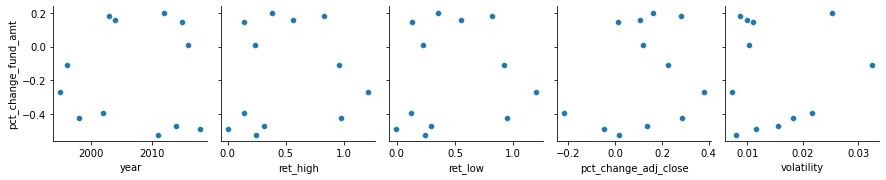

In [397]:
sns.pairplot(df_emerging4, x_vars=['year', 'ret_high', 'ret_low', 'pct_change_adj_close', 'volatility'],
            y_vars='pct_change_fund_amt')

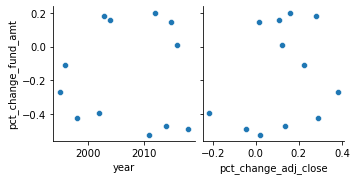

In [398]:
sns.pairplot(df_emerging4, x_vars=['year', 'pct_change_adj_close'],
            y_vars='pct_change_fund_amt')

In [399]:
# verify p-value

X_hist_em1 = df_emerging4[['year', 'open', 'ret_high', 'ret_low', 'volatility', 'pct_change_adj_close']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.188
Model:                             OLS   Adj. R-squared:                 -0.786
Method:                  Least Squares   F-statistic:                    0.1932
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.965
Time:                         14:14:32   Log-Likelihood:               -0.51241
No. Observations:                   12   AIC:                             15.02
Df Residuals:                        5   BIC:                             18.42
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   40.2657    464.040      0.087      0.934   -1152.588    1233.119
year                    -0.0198      0.230     -0.086      0.935      -0.611       0.572
open                    -0.0026      0.005     -0.482      0.650      -0.016       0.011
ret_high                -4.9593    148.329     -0.033      0.975    -386.250     376.332
ret_low                  3.2306    151.685      0.021      0.984    -386.687     393.149
volatility               6.7535    186.350      0.036      0.972    -472.274     485.781
pct_change_adj_close     3.2754      9.266      0.353      0.738     -20.543      27.094
==============================================================================
Omnibus:                        0.746   Durbin-Watson:                   2.644
Prob(Omnibus):                  0.689   Jarque-Bera (JB):                0.597
Skew:                          -0.026   Prob(JB):                        0.742
Kurtosis:                       1.909   Cond. No.                     8.75e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [400]:
# verify p-value

X_hist_em1 = df_emerging4[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'volatility',
                           'pct_change_adj_close']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.326
Model:                             OLS   Adj. R-squared:                 -0.854
Method:                  Least Squares   F-statistic:                    0.2762
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.934
Time:                         14:14:35   Log-Likelihood:                0.60252
No. Observations:                   12   AIC:                             14.79
Df Residuals:                        4   BIC:                             18.67
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  208.1879    507.980      0.410      0.703   -1202.189    1618.565
year                    -0.1031      0.252     -0.409      0.703      -0.802       0.596
open                     0.0005      0.006      0.081      0.939      -0.017       0.018
ret_high               158.2222    235.452      0.672      0.538    -495.497     811.941
ret_low               -160.9774    238.525     -0.675      0.537    -823.229     501.274
prev_yr_ret_high        -0.8073      0.893     -0.904      0.417      -3.287       1.673
volatility            -180.9494    281.389     -0.643      0.555    -962.212     600.313
pct_change_adj_close     1.8841      9.565      0.197      0.853     -24.673      28.441
==============================================================================
Omnibus:                        1.489   Durbin-Watson:                   2.889
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                0.589
Skew:                           0.541   Prob(JB):                        0.745
Kurtosis:                       2.918   Cond. No.                     1.05e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [401]:
# verify p-value

X_hist_em1 = df_emerging4[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 'volatility',
                           'pct_change_adj_close']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.364
Model:                             OLS   Adj. R-squared:                 -1.331
Method:                  Least Squares   F-statistic:                    0.2148
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.964
Time:                         14:14:38   Log-Likelihood:                0.95353
No. Observations:                   12   AIC:                             16.09
Df Residuals:                        3   BIC:                             20.46
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  166.6639    577.968      0.288      0.792   -1672.688    2006.015
year                    -0.0823      0.287     -0.287      0.793      -0.994       0.830
open                    -0.0015      0.009     -0.172      0.874      -0.029       0.026
ret_high               196.5316    278.992      0.704      0.532    -691.345    1084.408
ret_low               -199.5815    282.478     -0.707      0.531   -1098.551     699.388
prev_yr_ret_high        19.0259     46.662      0.408      0.711    -129.473     167.525
prev_yr_ret_low        -19.6595     46.243     -0.425      0.699    -166.824     127.505
volatility            -223.7454    331.221     -0.676      0.548   -1277.839     830.348
pct_change_adj_close     1.9297     10.727      0.180      0.869     -32.208      36.067
==============================================================================
Omnibus:                        2.701   Durbin-Watson:                   2.729
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                0.744
Skew:                           0.550   Prob(JB):                        0.689
Kurtosis:                       3.528   Cond. No.                     1.05e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [402]:
# verify p-value

X_hist_em1 = df_emerging4[['year', 'open', 'ret_high', 'ret_low', 'prev_yr_ret_high', 'prev_yr_ret_low', 'volatility',
                           'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.420
Model:                             OLS   Adj. R-squared:                 -2.188
Method:                  Least Squares   F-statistic:                    0.1611
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.980
Time:                         14:14:42   Log-Likelihood:                 1.5081
No. Observations:                   12   AIC:                             16.98
Df Residuals:                        2   BIC:                             21.83
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   45.7711    729.585      0.063      0.956   -3093.378    3184.920
year                    -0.0223      0.362     -0.062      0.957      -1.579       1.535
open                    -0.0050      0.013     -0.388      0.735      -0.060       0.050
ret_high               276.9199    373.916      0.741      0.536   -1331.911    1885.751
ret_low               -281.4988    379.172     -0.742      0.535   -1912.943    1349.945
prev_yr_ret_high       -97.3262    269.958     -0.361      0.753   -1258.861    1064.209
prev_yr_ret_low         98.5854    274.074      0.360      0.754   -1080.661    1277.832
volatility            -320.7435    445.659     -0.720      0.546   -2238.259    1596.772
prev_yr_volatility     161.4860    366.943      0.440      0.703   -1417.341    1740.313
pct_change_adj_close     3.5716     13.087      0.273      0.811     -52.739      59.882
==============================================================================
Omnibus:                        4.148   Durbin-Watson:                   3.007
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                1.369
Skew:                           0.692   Prob(JB):                        0.504
Kurtosis:                       3.906   Cond. No.                     1.05e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [403]:
# verify p-value

X_hist_em1 = df_emerging4[['ret_high', 'prev_yr_ret_high', 'volatility',
                           'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.233
Model:                             OLS   Adj. R-squared:                 -0.406
Method:                  Least Squares   F-statistic:                    0.3652
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.856
Time:                         14:14:45   Log-Likelihood:               -0.16920
No. Observations:                   12   AIC:                             12.34
Df Residuals:                        6   BIC:                             15.25
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2001      0.442     -0.453      0.667      -1.281       0.881
ret_high                 0.0159      1.491      0.011      0.992      -3.632       3.664
prev_yr_ret_high        -0.4333      0.745     -0.582      0.582      -2.256       1.390
volatility              10.2804     15.546      0.661      0.533     -27.758      48.319
prev_yr_volatility      -0.0362     30.234     -0.001      0.999     -74.016      73.943
pct_change_adj_close     0.8042      2.650      0.303      0.772      -5.681       7.290
==============================================================================
Omnibus:                        1.643   Durbin-Watson:                   2.583
Prob(Omnibus):                  0.440   Jarque-Bera (JB):                1.075
Skew:                           0.690   Prob(JB):                        0.584
Kurtosis:                       2.502   Cond. No.                         388.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [404]:
# verify p-value

X_hist_em1 = df_emerging4[['ret_low', 'prev_yr_ret_low', 'volatility',
                           'prev_yr_volatility', 'pct_change_adj_close']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.233
Model:                             OLS   Adj. R-squared:                 -0.405
Method:                  Least Squares   F-statistic:                    0.3653
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.856
Time:                         14:14:51   Log-Likelihood:               -0.16873
No. Observations:                   12   AIC:                             12.34
Df Residuals:                        6   BIC:                             15.25
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2007      0.442     -0.454      0.665      -1.281       0.880
ret_low                  0.0152      1.500      0.010      0.992      -3.655       3.686
prev_yr_ret_low         -0.4354      0.753     -0.578      0.584      -2.279       1.408
volatility              10.3310     15.313      0.675      0.525     -27.138      47.800
prev_yr_volatility      -0.3932     31.063     -0.013      0.990     -76.402      75.615
pct_change_adj_close     0.8064      2.641      0.305      0.770      -5.656       7.269
==============================================================================
Omnibus:                        1.645   Durbin-Watson:                   2.579
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.075
Skew:                           0.690   Prob(JB):                        0.584
Kurtosis:                       2.504   Cond. No.                         392.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [405]:
# verify p-value

X_hist_em1 = df_emerging4[['ret_low', 'prev_yr_ret_low', 'volatility',
                           'prev_yr_volatility']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.221
Model:                             OLS   Adj. R-squared:                 -0.223
Method:                  Least Squares   F-statistic:                    0.4978
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.739
Time:                         14:15:01   Log-Likelihood:               -0.26124
No. Observations:                   12   AIC:                             10.52
Df Residuals:                        7   BIC:                             12.95
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1091      0.302     -0.361      0.729      -0.824       0.606
ret_low                0.4556      0.384      1.186      0.274      -0.453       1.364
prev_yr_ret_low       -0.6121      0.450     -1.360      0.216      -1.676       0.452
volatility             9.6313     14.126      0.682      0.517     -23.771      43.033
prev_yr_volatility    -8.4600     15.243     -0.555      0.596     -44.504      27.584
==============================================================================
Omnibus:                        1.503   Durbin-Watson:                   2.649
Prob(Omnibus):                  0.472   Jarque-Bera (JB):                1.082
Skew:                           0.663   Prob(JB):                        0.582
Kurtosis:                       2.365   Cond. No.                         206.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [406]:
# verify p-value

X_hist_em1 = df_emerging4[['ret_low', 'prev_yr_ret_low',
                           'prev_yr_volatility']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.170
Model:                             OLS   Adj. R-squared:                 -0.142
Method:                  Least Squares   F-statistic:                    0.5453
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.665
Time:                         14:15:11   Log-Likelihood:               -0.64704
No. Observations:                   12   AIC:                             9.294
Df Residuals:                        8   BIC:                             11.23
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0140      0.259     -0.054      0.958      -0.611       0.583
ret_low                0.3945      0.361      1.094      0.306      -0.437       1.226
prev_yr_ret_low       -0.4750      0.389     -1.221      0.257      -1.372       0.422
prev_yr_volatility    -7.7320     14.688     -0.526      0.613     -41.603      26.139
==============================================================================
Omnibus:                        2.260   Durbin-Watson:                   2.936
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                0.971
Skew:                           0.186   Prob(JB):                        0.615
Kurtosis:                       1.657   Cond. No.                         203.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [407]:
# verify p-value

X_hist_em1 = df_emerging4[['ret_high', 'prev_yr_ret_high',
                           'prev_yr_volatility']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.175
Model:                             OLS   Adj. R-squared:                 -0.134
Method:                  Least Squares   F-statistic:                    0.5656
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.653
Time:                         14:15:22   Log-Likelihood:               -0.60911
No. Observations:                   12   AIC:                             9.218
Df Residuals:                        8   BIC:                             11.16
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0171      0.257     -0.067      0.949      -0.610       0.576
ret_high               0.4014      0.359      1.119      0.296      -0.426       1.228
prev_yr_ret_high      -0.4837      0.389     -1.244      0.249      -1.380       0.413
prev_yr_volatility    -7.4092     14.431     -0.513      0.622     -40.688      25.870
==============================================================================
Omnibus:                        2.041   Durbin-Watson:                   2.929
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                0.945
Skew:                           0.209   Prob(JB):                        0.624
Kurtosis:                       1.691   Cond. No.                         203.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [409]:
# verify p-value

X_hist_em1 = df_emerging4[['ret_high', 'prev_yr_ret_high']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.148
Model:                             OLS   Adj. R-squared:                 -0.042
Method:                  Least Squares   F-statistic:                    0.7805
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.487
Time:                         14:18:09   Log-Likelihood:               -0.80361
No. Observations:                   12   AIC:                             7.607
Df Residuals:                        9   BIC:                             9.062
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1164      0.162     -0.716      0.492      -0.484       0.251
ret_high             0.3033      0.291      1.043      0.324      -0.355       0.961
prev_yr_ret_high    -0.3856      0.325     -1.188      0.265      -1.120       0.349
==============================================================================
Omnibus:                        4.034   Durbin-Watson:                   2.818
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                1.293
Skew:                           0.279   Prob(JB):                        0.524
Kurtosis:                       1.492   Cond. No.                         5.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [408]:
# verify p-value

X_hist_em1 = df_emerging4[['prev_yr_ret_high']]

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, x_prime_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pct_change_fund_amt   R-squared:                       0.045
Model:                             OLS   Adj. R-squared:                 -0.051
Method:                  Least Squares   F-statistic:                    0.4692
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):              0.509
Time:                         14:15:29   Log-Likelihood:                -1.4882
No. Observations:                   12   AIC:                             6.976
Df Residuals:                       10   BIC:                             7.946
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0745      0.158     -0.471      0.648      -0.427       0.278
prev_yr_ret_high    -0.1746      0.255     -0.685      0.509      -0.743       0.393
==============================================================================
Omnibus:                        5.410   Durbin-Watson:                   2.776
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                1.322
Skew:                          -0.046   Prob(JB):                        0.516
Kurtosis:                       1.377   Cond. No.                         3.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### [ignore] historical S&P data, 1978-2022

In [268]:
df_sp = pd.read_csv('HistoricalPrices1978.csv')
df_sp

,Date,Open,High,Low,Close
0,05/11/22,3990.08,4049.09,3928.82,3935.18
1,05/10/22,4035.18,4068.82,3958.17,4001.05
2,05/09/22,4081.27,4081.27,3975.48,3991.24
3,05/06/22,4128.17,4157.69,4067.91,4123.34
4,05/05/22,4270.43,4270.43,4106.01,4146.87
...,...,...,...,...,...
11181,01/09/78,90.64,91.52,90.01,90.64
11182,01/06/78,91.62,92.66,91.05,91.62
11183,01/05/78,92.74,94.53,92.51,92.74
11184,01/04/78,93.52,94.10,93.16,93.52


In [269]:
df_sp[["day", "month", "year"]] = df_sp["Date"].str.split("/", expand = True)
df_sp.head()

,Date,Open,High,Low,Close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [270]:
df_sp = df_sp.rename(columns={'Date':'date', ' Open':'open', ' High':'high', ' Low':'low',
                             ' Close':'close'})
df_sp.head()

,date,open,high,low,close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [271]:
df_sp['avg_open_yr'] = df_sp.groupby(df_sp['year'])['open'].transform('mean')
df_sp['avg_high_yr'] = df_sp.groupby(df_sp['year'])['high'].transform('mean')
df_sp['avg_low_yr'] = df_sp.groupby(df_sp['year'])['low'].transform('mean')
df_sp.head()

,date,open,high,low,close,day,month,year,avg_open_yr,avg_high_yr,avg_low_yr
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22,4423.340444,4458.361111,4374.597222
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22,4423.340444,4458.361111,4374.597222
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22,4423.340444,4458.361111,4374.597222
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22,4423.340444,4458.361111,4374.597222
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22,4423.340444,4458.361111,4374.597222


In [272]:
df_sp_yr = df_sp[['year', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_yr.head()

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
1,22,4423.340444,4458.361111,4374.597222
2,22,4423.340444,4458.361111,4374.597222
3,22,4423.340444,4458.361111,4374.597222
4,22,4423.340444,4458.361111,4374.597222


In [273]:
df_sp_final = df_sp_yr.drop_duplicates()
df_sp_final

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
90,21,4271.170714,4291.877579,4251.042698
342,20,3217.750277,3242.183953,3190.484466
595,19,2911.627619,2923.622341,2899.439921
847,18,2747.784900,2762.655418,2730.275259
1098,17,2448.275896,2454.344821,2441.850677
1349,16,2094.091548,2103.306865,2083.753135
1601,15,2061.268016,2071.863095,2049.309524
1853,14,1930.754484,1938.835595,1922.292976
2105,13,1642.295516,1649.615714,1635.737024


In [274]:
df_sp_final['year'] = df_sp_final['year'].astype(int)

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_37432/2375293518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['year'] = df_sp_final['year'].astype(int)


In [275]:
df_sp_final.dtypes

year             int64
avg_open_yr    float64
avg_high_yr    float64
avg_low_yr     float64
dtype: object

In [278]:
years = df_sp_final['year'].values.tolist()

In [279]:
converted_yrs = []

for i in years:
    if i <= 23:
        i+=2000
        converted_yrs.append(i)
    else:
        i+=1900
        converted_yrs.append(i)

In [280]:
df_sp_final['converted_years'] = converted_yrs
df_sp_final = df_sp_final[['converted_years', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_final.head()

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_37432/1249340593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['converted_years'] = converted_yrs


,converted_years,avg_open_yr,avg_high_yr,avg_low_yr
0,2022,4423.340444,4458.361111,4374.597222
90,2021,4271.170714,4291.877579,4251.042698
342,2020,3217.750277,3242.183953,3190.484466
595,2019,2911.627619,2923.622341,2899.439921
847,2018,2747.784900,2762.655418,2730.275259


### [ignore] buyouts: funds

In [281]:
df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
0,34866,Ascent Venture Partners VII,6381,Venture Capital / Growth Equity,TMT,North America,United States,150000000.0,USD,NaN,NaN,Launched,NaN,2020,2020-0
1,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,TMT,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
2,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,Agribusiness,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
3,39769,Star Mountain U.S. LMM Secondary Fund II,1671,Secondaries,Diversified,North America,United States,500000000.0,USD,200000000.0,USD,Currently Investing,1st Close,2020,2020-12
4,43372,Waterfall Sentinel Fund I,19136,Buyout / Corporate Private Equity,Diversified,North America,United States,300000000.0,USD,80000000.0,USD,Currently Investing,1st Close,2019,2019-1


In [282]:
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6950,62131,Corridor Capital Title II,12869,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,13260000.0,USD,Launched,NaN,2022,2022-4
6177,61228,Altera Vision PA,22927,Venture Capital / Growth Equity,Diversified,North America,NaN,5250000.0,USD,3560000.0,USD,Currently Investing,1st Close,2022,2022-2
6193,61238,Third Lake PC NCBDC Fund,20727,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-2
6192,61237,Barings CMS Fund,2161,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-0
6189,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Middle East/Africa,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [283]:
df_funds.tail()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
570,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
569,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,Business Services,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
568,49075,Elephant Partners III,16906,Venture Capital / Growth Equity,TMT,North America,United States,350000000.0,USD,NaN,NaN,Currently Investing,1st Close,2019,2019-11
567,49057,RCP Small & Emerging Fund II,1780,Fund of Funds / Co-Investment,Diversified,North America,United States,200000000.0,USD,123230000.0,USD,Currently Investing,5th Close,2019,2019-11
3475,56899,Renegade Partners I,22225,Venture Capital / Growth Equity,TMT,North America,NaN,300000000.0,USD,100000000.0,USD,Currently Investing,1st Close,2019,2020-3


### [ignore] buyouts: LP commitments

In [284]:
df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
0,215027,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
1,195565,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
2,181373,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
3,125752,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
4,88550,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Western Europe,2011


In [285]:
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [286]:
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [287]:
df_lp.tail()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
42682,103572,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
42683,11756,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,TMT,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
84678,169189,542,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,50000000.0,USD,North America,1978
217369,131578,14598,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976
224583,221613,15532,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976


In [288]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby("vintage_year")['fund_size_amt'].transform('mean')
#df_lp.head()

In [289]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
0,1976,6.800000e+06,NaN
1,1978,1.600000e+07,1.835733e+07
2,1979,3.135000e+07,2.000000e+06
3,1980,7.699545e+07,4.332000e+07
4,1981,3.552000e+07,3.865455e+07
5,1982,3.815125e+08,7.548600e+06
6,1983,1.448451e+08,1.641667e+07
7,1984,1.040575e+08,1.113846e+07
8,1985,1.138329e+08,1.055661e+07
9,1986,5.510820e+08,7.628571e+06


In [290]:
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [291]:
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [292]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby('vintage_year').agg({'fund_size_amt':'mean', 
                                                               #'commitment_amt':'mean'})


In [293]:
#df_lp_final = df_lp_grouped.drop_duplicates(subset=['vintage_year', 'avg_fund_size_amt'])
#df_lp_final

### [ignore] S&P + LP commitments

In [294]:
df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})
df_sp_merge = df_sp_final.rename(columns={'converted_years':'year', 'avg_open_yr':'avg_open',
                                         'avg_high_yr':'avg_high', 'avg_low_yr':'avg_low'})
df_merged = pd.merge(df_sp_merge, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged

,year,avg_open,avg_high,avg_low,avg_fund_size_amt,avg_commitment_amt
44,1978,96.117778,96.801190,95.438214,1.600000e+07,1.835733e+07
43,1979,102.980833,103.474048,102.436111,3.135000e+07,2.000000e+06
42,1980,118.713913,119.416403,117.958182,7.699545e+07,4.332000e+07
41,1981,128.038142,129.355968,126.784427,3.552000e+07,3.865455e+07
40,1982,119.705494,121.041107,118.405652,3.815125e+08,7.548600e+06
39,1983,160.473043,161.929091,158.898933,1.448451e+08,1.641667e+07
38,1984,160.463636,161.312885,159.679289,1.040575e+08,1.113846e+07
37,1985,186.828175,187.415754,186.064524,1.138329e+08,1.055661e+07
36,1986,236.391858,237.463913,234.950356,5.510820e+08,7.628571e+06
35,1987,286.995889,289.283439,284.524190,7.904181e+08,2.796233e+07


In [295]:
df_merged['avg_high'].corr(df_merged['avg_fund_size_amt'])

0.7632889955588487

In [296]:
df_merged['avg_low'].corr(df_merged['avg_fund_size_amt'])

0.7649360242313832

In [297]:
df_merged['avg_high'].corr(df_merged['avg_commitment_amt'])

0.39660694898994586

In [298]:
df_merged['avg_low'].corr(df_merged['avg_commitment_amt'])

0.39935689323545853

In [299]:
X = df_merged[['year', 'avg_open', 'avg_high', 'avg_low', 'avg_commitment_amt']]
y = df_merged.avg_fund_size_amt

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [301]:
pipe = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [302]:
lasso = pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.320289729290673e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [303]:
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso['lasso'].coef_ != 0))

Test set score: 0.80
Number of features used: 5


In [304]:
X2 = df_merged[['year', 'avg_open', 'avg_high', 'avg_commitment_amt']]

In [305]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.1, random_state=0)

In [306]:
lasso2 = pipe.fit(X_train2, y_train2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3510501794343813e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [307]:
print("Test set score: {:.2f}".format(lasso2.score(X_test2, y_test2)))
print("Number of features used:", np.sum(lasso2['lasso'].coef_ != 0))

Test set score: 0.81
Number of features used: 4


In [308]:
X3 = df_merged[['avg_open', 'avg_high', 'avg_commitment_amt']]

In [309]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.1, random_state=0)

In [310]:
lasso3 = pipe.fit(X_train3, y_train3)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.916409427215324e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [311]:
print("Test set score: {:.2f}".format(lasso3.score(X_test3, y_test3)))
print("Number of features used:", np.sum(lasso3['lasso'].coef_ != 0))

Test set score: 0.72
Number of features used: 3


In [312]:
param_grid={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [313]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=-1)

In [314]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8195043507480035e+19, tolerance: 1.5590305779438276e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9409855358124528e+19, tolerance: 1.8669686279674744e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.035362651104777e+19, tolerance: 1.8894652170089156e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.818828162710499e+19, tolerance: 1.5590305779438276e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9610222260645085e+19, tolerance: 1.8502517141135704e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.954960628472115e+19, tolerance: 1.872979959097456e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [315]:
print("Score for the best model: {:.2f}".format(grid.score(X_test, y_test)))

Score for the best model: 0.75


In [316]:
grid.best_params_

{'lasso__alpha': 10000000.0, 'lasso__max_iter': 10000}

In [317]:
grid.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=10000000.0, max_iter=10000))])